# Taxabarplots

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorcet as cc
import matplotlib.patches as mpatches
%matplotlib inline 

!mkdir Figures
def bar_unzip(qza,lev):  
  a = !unzip $qza
  digest = a[1].split('/')[0].replace('  inflating: ','')
  inf = digest + '/data/level-%s.csv'%lev
  data = pd.read_csv(inf, sep=',',index_col=0)
  !rm -r $digest
  return data
  
def taxamod(df,lev):
  taxa = df[[col for col in df.columns if 'd__' in col]].T
  taxa['Taxon'] = taxa.index.str.strip(';__')
  tax_rep = {';__':'','[':'',']':'','.':'','/':'_',"'":'_',' ':'_','archaeon_enrichment':'a_e','group':'gr',
             'uncultured_rumen':'uncl','uncultured_archaeon':'uncl','uncultured_euryarchaeote':'uncl',
             'uncultured_compost':'uncl','_archaeon':'uncl','unidentified':'unid','unid_rumen':'unid',
             'uncultured_bacterium':'uncl','uncultured':'uncl','rumen_bacterium':'uncl','p-251-o5':'uncl_p-251-o5',
             '_gr':'','F082':'Bacteroidales_(F082)','WPS-2':'uncl_WPS-2','\(Marine_B\)':'',}
  taxa['Taxon2'] = taxa['Taxon']
  for key in tax_rep.keys():
    taxa['Taxon2'] = taxa['Taxon2'].str.replace(key, tax_rep[key])
  taxa['Combo'] =  taxa['Taxon2'].str.split("__").str[-1].str.split(";").str[-1]
  for x in ['uncl','unid_methanogen','unid','methanogenic_a','u_methanogenic_a','UCG-004']:
    taxa.loc[taxa['Combo'].str[:]==x,'Combo']=taxa['Taxon2'].str.split("__").str[-2].str.split(';').str[0]+'_'+x
  if lev >= 6: #modified
    for n in range(3,6):
      for y in ['uncl_uncl','unid_unid','unid_uncl','uncl_unid','methanogenic_uncl']:
        taxa.loc[taxa.Combo.str[:]==y,'Combo']=taxa.Taxon2.str.split("__").str[-n].str.split(';').str[0]+'_'+y.split('_',1)[1]
  taxa.set_index('Combo',inplace=True)
  taxa.index = taxa.index.str.replace('NK3A20','(NK3A20)').str.replace('YAB2003','(YAB2003)')\
    .str.replace('_7',' (7)').str.replace('p-251-o5','(p-251-o5)').str.replace('ceae_uncl','ceae')\
    .str.replace('R-7','(R-7)').str.replace('RC9_gut','(RC9 gut)').str.replace('RF16','(RF16)')\
    .str.replace('UCG-001','(UCG-001)').str.replace('_nodatum','').str.replace('_',' ')
  taxa.drop(['Taxon','Taxon2'],axis=1,inplace=True)
  return taxa.T

plt.rcParams['axes.linewidth'] = .5 #adjust line width
names = {'Trt1':'TMR','Trt2':'AN2.5','Trt3':'AN5','Trt4':'FV2.5','Trt5':'FV5',}
colours = cc.glasbey_hv
del colours[26]

domens = {'arc':'Archaeal','bac':'Bacterial'}

mkdir: cannot create directory ‘Figures’: File exists


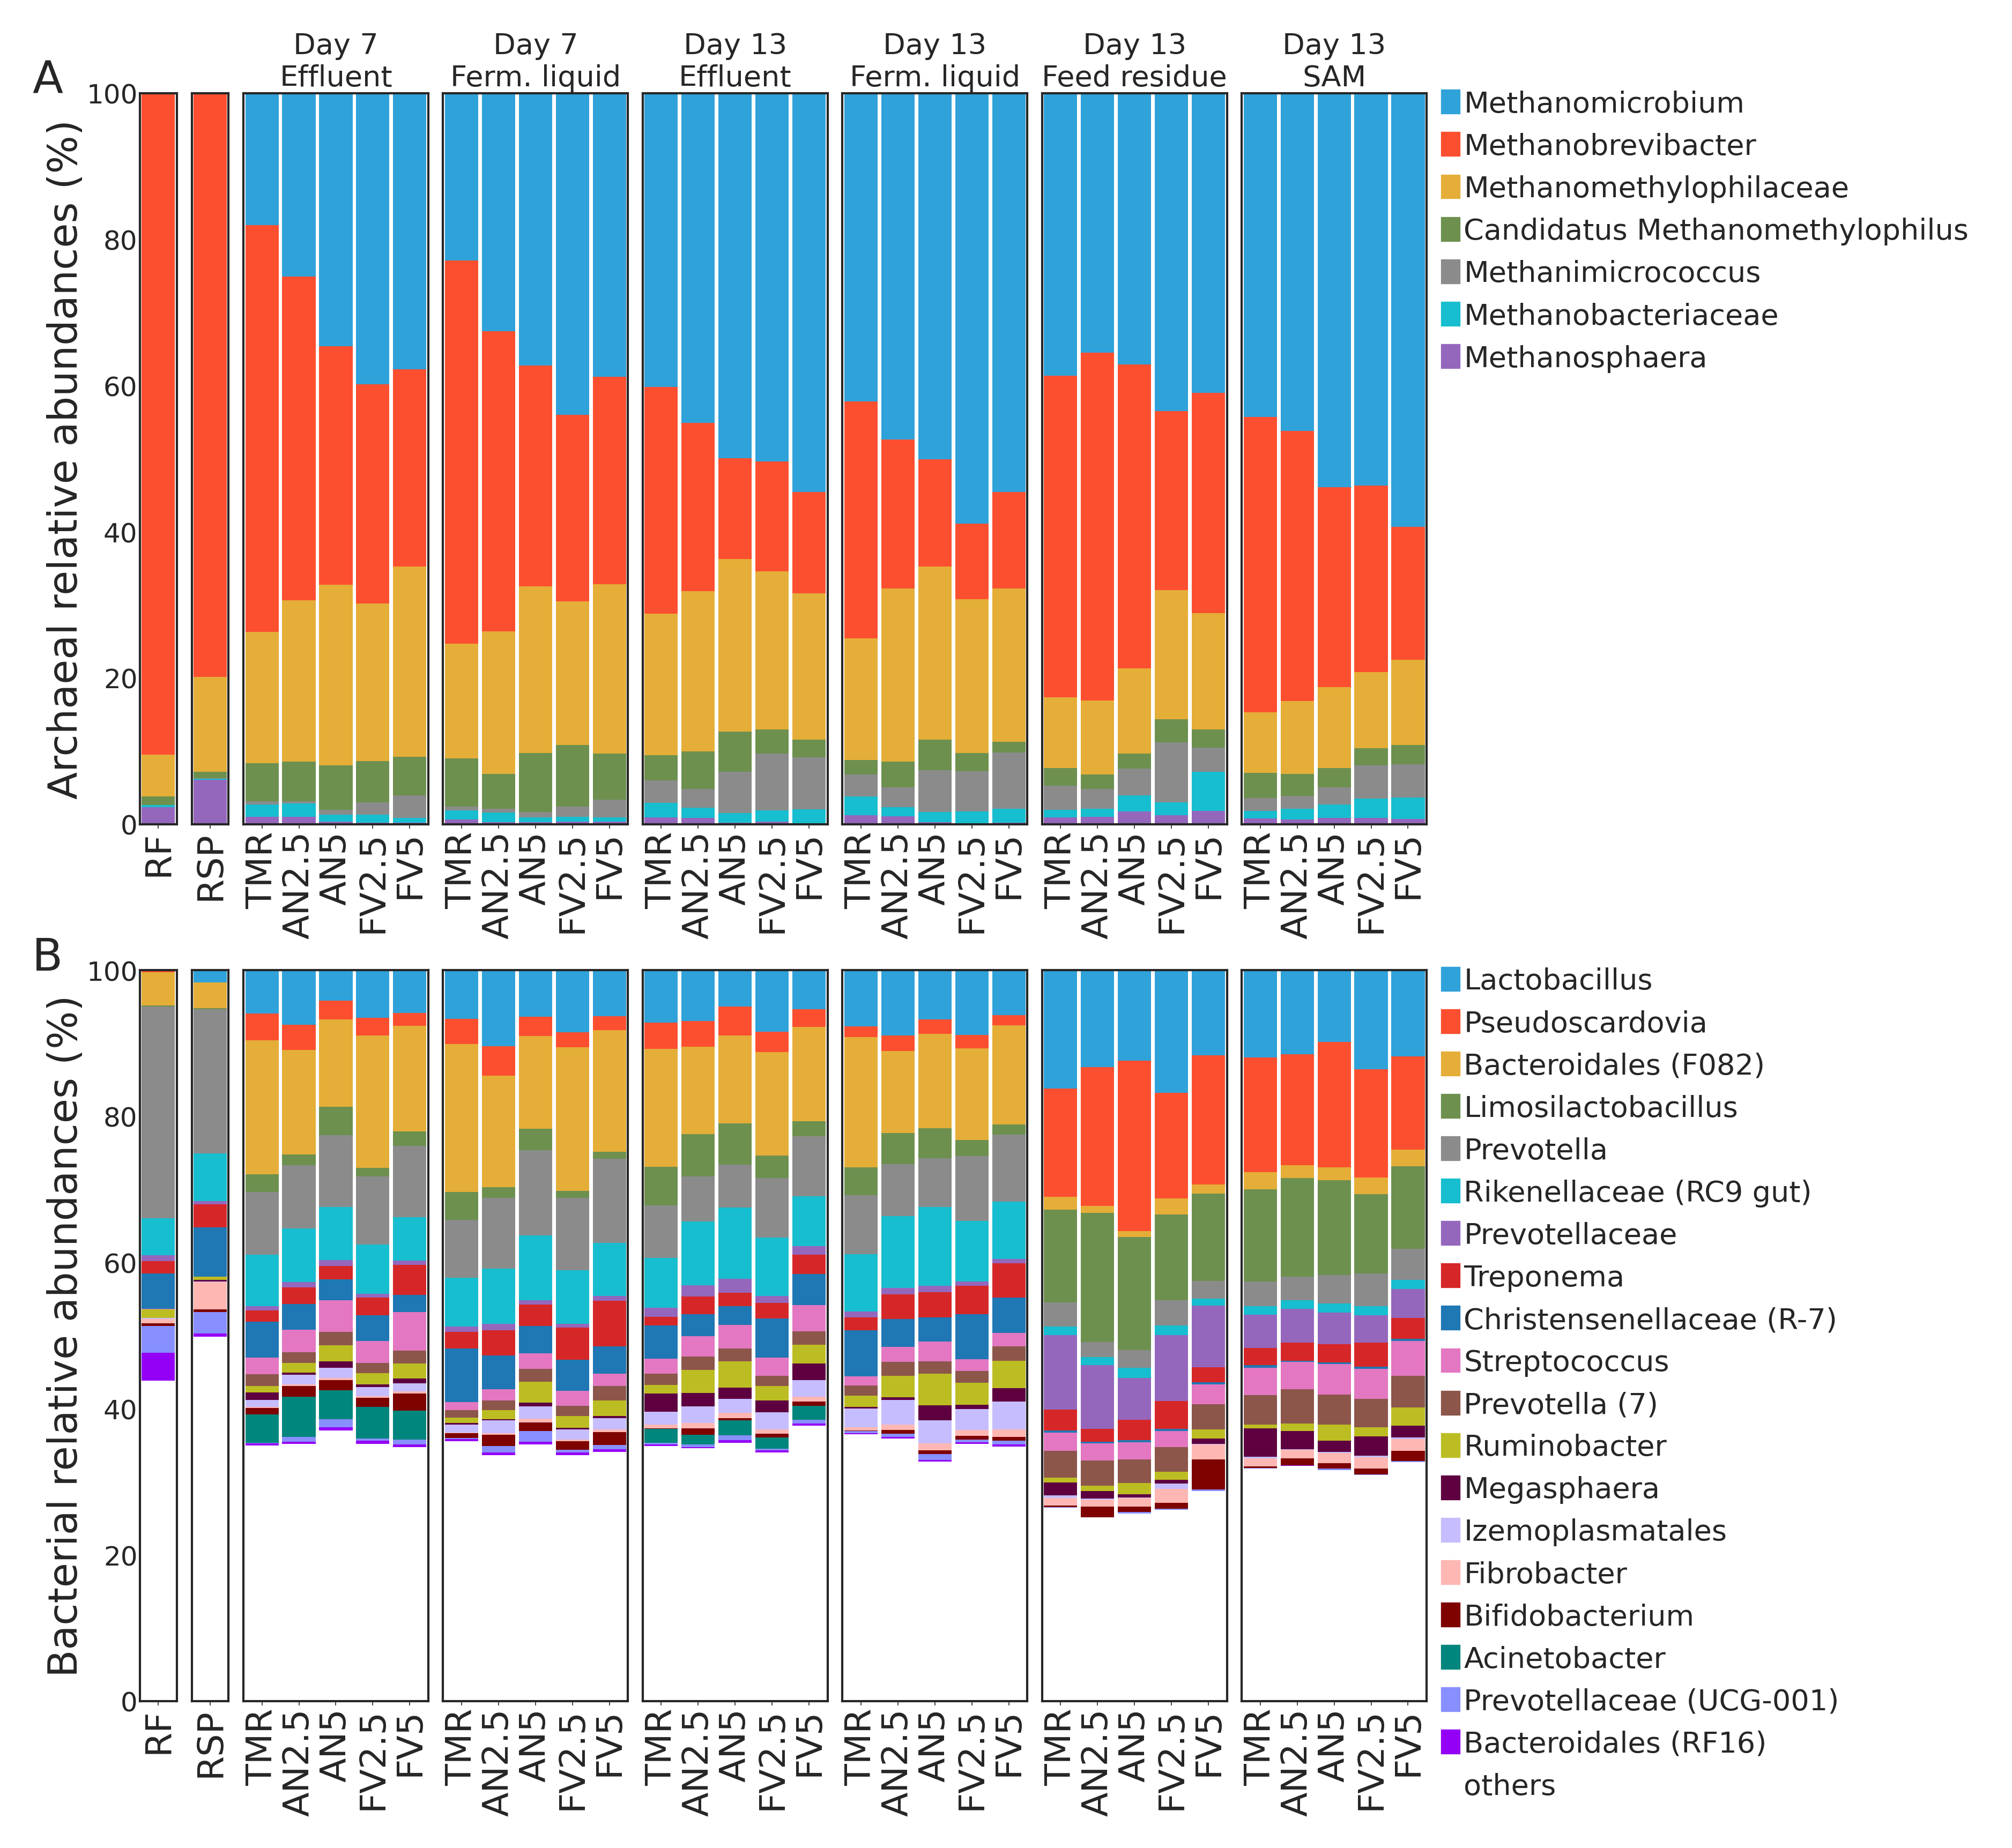

In [25]:
stypes = {'E':'Effluent','FL':'Ferm. liquid','FR':'Feed residue','SAM':'SAM'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col=0)

ratios = [len(meta.loc[meta.BS_Day==g].Treatment.unique()) for g in meta.BS_Day.unique()] #get wildth ratios
fig,axes = plt.subplots(2,8,figsize=(4,5),dpi=600,gridspec_kw={'wspace':.1,'hspace':.2,'width_ratios':ratios},sharey='row')
axs,i = [[n,m] for n in range(2) for m in range(8)],0

for dom in domens:
  legend = []
  df = taxamod(bar_unzip('rstc_2019_%s/Results/Taxa_barplots/full-taxabarplot.qzv'%dom,6),6)
  df = df.groupby(level=0,axis=1).sum()                       #sum duplicates
  df = df.append(df.agg(['sum']))                             #add a row with sum 
  df.sort_values(inplace=True,axis=1,by='sum',ascending=True) #sort features by sum of abundances
  df.drop(inplace=True,index='sum')
  df = df.div(df.sum(axis=1),axis=0)*100                      #convert to % (rel ab)
  meta = pd.read_csv('rstc_2019_%s/metadata.tsv'%dom,sep='\t',index_col=0)
  meta = meta.loc[df.index.tolist(),:]                        #remove filtered samples from metadata 
  meta = meta.sort_values(['Day_num','BS','Treatment'],ascending=[True,True,True]) #sort df
  
  cdict = dict(zip(df.columns.tolist()[::-1], colours))       #create a colorbar for legend
  data = pd.DataFrame()                                       #store mean rel ab by sample-type, day and treatment
  for g in meta.BS_Day_Trt.unique():
    tempmet = meta.loc[meta.BS_Day_Trt==g].copy()
    tempdf = df.copy().drop([i for i in df.index if i not in tempmet.index])
    for col in tempdf.columns:
      data.loc[g,col]=tempdf[col].mean()
  for col in data.columns:                                    # remove low abundant features 
    if data[col].max() < 3.5: 
      data = data.drop(col,axis=1)
  for group in meta.BS_Day.unique():             #iterate through sample-types by days
    ax, i = axes[axs[i][0]][axs[i][1]], i+1
    submet = meta.loc[meta.BS_Day==group].copy()
    subdata = data.loc[[j for j in data.index if j in submet.BS_Day_Trt.tolist()],:]  #data to plot
    subdata.index = subdata.index.str.replace('_d0_not_appl','')
    bottom = [100-subdata.loc[j,:].sum() for j in subdata.index]
    for col in subdata.columns:      # iterate through all features
      c = cdict[col]
      if col not in legend: legend = [col]+legend
      ax.bar(x=subdata.index,height=subdata[col],bottom=bottom,color=c,label=col,width=0.9,linewidth=.0)
      bottom = [a+b for a,b in zip(bottom, subdata[col].tolist())]  
    ax.tick_params(axis='both',labelsize=6,pad=0.5,length=0,width=0.2)   # adjust ticks
    ax.tick_params(axis='x',labelrotation=90,length=1,labelsize=8)      # adjust ticks
    ax.set_ylim(0,100)                                                   # set limit for y axis
    ax.set_xlim(-0.5,len(subdata.index)-0.5)
    order = subdata.index
    ax.set_ylabel(domens[dom]+' relative abundances (%)',fontsize=9,labelpad=0.1)
    ax.set_xticklabels([names[x[-4:]] if '_' in x else x for x in order])
    if group != meta.BS_Day.unique()[0]: ax.set_ylabel('')
    else: ax.text(-2.5,1,'AB'[list(domens.keys()).index(dom)],ha='center',fontsize=10,transform=ax.transAxes)
    if group not in meta.BS_Day.unique()[:2] and dom == 'arc':
      title = 'Day '+ group.split('_')[-1][1:] +'\n'+ stypes[group.split('_')[0]]
      ax.text(2,101,title,ha='center',fontsize=6.5)
    if group == meta.BS_Day.unique()[-1]:
      labels = [f for f in data.columns[::-1] if f in legend]
      if dom == 'bac': labels += ['others']           
      handles = [mpatches.Patch(fill=False,edgecolor='none',visible=False) if l == 'others' \
                 else mpatches.Patch(color=cdict[l],label=l) for l in labels]
      leg = ax.legend(handles,labels,loc=2,bbox_to_anchor=(.95,1.04),fontsize=6.5,frameon=False,
                      handletextpad=0.2,handlelength=0.5,bbox_transform=ax.transAxes,)  
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig('Figures/Taxabarplot.png', bbox_inches='tight')

## Statistical analysis of top features in barplots

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scikit_posthocs import posthoc_dunn as dunn
from statsmodels.stats.multitest import multipletests
from itertools import combinations

        
def bar_unzip(qza,lev):  
  a = !unzip $qza
  digest = a[1].split('/')[0].replace('  inflating: ','')
  inf = digest + '/data/level-%s.csv'%lev
  data = pd.read_csv(inf, sep=',',index_col=0)
  !rm -r $digest
  return data
  
def taxamod(df,lev):
  taxa = df[[col for col in df.columns if 'd__' in col]].T
  taxa['Taxon'] = taxa.index.str.strip(';__')
  tax_rep = {';__':'','[':'',']':'','.':'','/':'_',"'":'_',' ':'_','archaeon_enrichment':'a_e','group':'gr',
             'uncultured_rumen':'uncl','uncultured_archaeon':'uncl','uncultured_euryarchaeote':'uncl',
             'uncultured_compost':'uncl','_archaeon':'uncl','unidentified':'unid','unid_rumen':'unid',
             'uncultured_bacterium':'uncl','uncultured':'uncl','rumen_bacterium':'uncl','p-251-o5':'uncl_p-251-o5',
             '_gr':'','F082':'uncl_F082','WPS-2':'uncl_WPS-2','\(Marine_B\)':'',}
  taxa['Taxon2'] = taxa['Taxon']
  for key in tax_rep.keys():
    taxa['Taxon2'] = taxa['Taxon2'].str.replace(key, tax_rep[key])
  taxa['Combo'] =  taxa['Taxon2'].str.split("__").str[-1].str.split(";").str[-1]
  for x in ['uncl','unid_methanogen','unid','methanogenic_a','u_methanogenic_a','UCG-004']:
    taxa.loc[taxa['Combo'].str[:]==x,'Combo']=taxa['Taxon2'].str.split("__").str[-2].str.split(';').str[0]+'_'+x
  if lev >= 6: #modified
    for n in range(3,6):
      for y in ['uncl_uncl','unid_unid','unid_uncl','uncl_unid','methanogenic_uncl']:
        taxa.loc[taxa.Combo.str[:]==y,'Combo']=taxa.Taxon2.str.split("__").str[-n].str.split(';').str[0]+'_'+y.split('_',1)[1]
  taxa.set_index('Combo',inplace=True)
  taxa.index = taxa.index.str.replace('NK3A20','(NK3A20)').str.replace('YAB2003','(YAB2003)')\
    .str.replace('_7',' (7)').str.replace('YAB2003','(YAB2003)').str.replace('_F082','. bact. (F082)')\
    .str.replace('R-7','(R-7)').str.replace('RC9_gut','(RC9 gut)').str.replace('RF16','(RF16)')\
    .str.replace('UCG-001','(UCG-001)').str.replace('_',' ')
  taxa.drop(['Taxon','Taxon2'],axis=1,inplace=True)
  return taxa.T

def kw_dunn(df,col,metric,pairwise):
  phoc = pd.DataFrame(columns=['Group1','Group2','p','q'])
  kw = stats.kruskal(*[g[metric].values for n,g in df.groupby(col)])
  if kw[1] < 0.05 and pairwise==True:
    dunn_p = dunn(df,val_col=metric,group_col=col)
    dunn_q = dunn(df,val_col=metric,group_col=col,p_adjust='fdr_bh')
    for i,pair in enumerate(combinations(set(df[col].tolist()),2)):
      phoc.loc[len(phoc)]=[pair[0],pair[1],dunn_p.loc[pair[0],pair[1]],dunn_q.loc[pair[0],pair[1]]]
  return kw,phoc

names = {'Trt1':'TMR','Trt2':'AN2.5','Trt3':'AN5','Trt4':'FV2.5','Trt5':'FV5',}
domens = {'arc':6,'bac':20}
!mkdir Figures/Taxa_pairwise

for dom in domens:
  meta = pd.read_csv('rstc_2019_%s/metadata.tsv'%dom,sep='\t',index_col=0)
  df = taxamod(bar_unzip('rstc_2019_%s/Results/Taxa_barplots/full-taxabarplot.qzv'%dom,6),6)
  df = df.groupby(lambda x:x, axis=1).sum()
  df = df.append(df.agg(['sum']))                             # add a row with sum 
  df.sort_values(inplace=True,axis=1,by='sum',ascending=False) # sort features by sum of abundances
  df.drop(inplace=True,index='sum')
  df = df.iloc[:,:domens[dom]]
  meta = meta.loc[df.index.tolist(),:]
  meta = meta.sort_values(['Day_num','BS','Treatment'],ascending=[True,True,True])
  data = pd.concat([meta, df], axis=1)
  
  # Between sample-types and days of sampling
  i = 0
  summary = pd.DataFrame()
  for feat in df.columns:
    kw,phoc = kw_dunn(data.copy(),'BS_Day',feat,pairwise=True)
    if kw[1] <= 0.05:
      for ind in phoc.index:
        summary.loc[i,'Feature'] = feat
        summary.loc[i,'KW'] = kw[1]
        summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
        summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
        summary.loc[i,'p'] = phoc.loc[ind,'p']
        summary.loc[i,'q'] = phoc.loc[ind,'q']
        i += 1
    else:
      summary.loc[i,'Feature'] = feat
      summary.loc[i,'KW'] = kw[1]
      summary.loc[i,'Group1'] = '-'
      summary.loc[i,'Group2'] = '-'
      summary.loc[i,'p'] = '-'
      summary.loc[i,'q'] = '-'
      i += 1
  summary.to_csv('Figures/Taxa_pairwise/Between_BS_Day_%s.tsv'%dom,sep='\t')
  
  # Between treatments within sample-types and days of sampling
  i = 0
  summary = pd.DataFrame()
  for group in data.BS_Day.unique():
    if group in ['RSP_d0','RF_d0']: continue
    subdata = data.loc[data.BS_Day==group].copy()
    for feat in df.columns:
      kw,phoc = kw_dunn(subdata.copy(),'Treatment',feat,pairwise=True)
      if kw[1] <= 0.05:
        for ind in phoc.index:
          summary.loc[i,'Group'] = group
          summary.loc[i,'Feature'] = feat
          summary.loc[i,'KW'] = kw[1]
          summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
          summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
          summary.loc[i,'p'] = phoc.loc[ind,'p']
          summary.loc[i,'q'] = phoc.loc[ind,'q']
          i += 1
      else:
        summary.loc[i,'Group'] = group
        summary.loc[i,'Feature'] = feat
        summary.loc[i,'KW'] = kw[1]
        summary.loc[i,'Group1'] = '-'
        summary.loc[i,'Group2'] = '-'
        summary.loc[i,'p'] = '-'
        summary.loc[i,'q'] = '-'
        i += 1
  summary.to_csv('Figures/Taxa_pairwise/Between_Treatments_%s.tsv'%dom,sep='\t')

mkdir: cannot create directory ‘Figures/Taxa_pairwise’: File exists


# Alpha diversity pairwise sample-types within days

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats
from scikit_posthocs import posthoc_dunn as dunn
from statsmodels.stats.multitest import multipletests
from statannot import add_stat_annotation
from itertools import combinations
%matplotlib inline
sns.set_style("ticks")

def kw_dunn(df,col,metric,pairwise):
  phoc = pd.DataFrame(columns=['Group1','Group2','p','q'])
  kw = stats.kruskal(*[g[metric].values for n,g in df.groupby(col)])
  if kw[1] < 0.05 and pairwise==True:
    dunn_p = dunn(df,val_col=metric,group_col=col)
    dunn_q = dunn(df,val_col=metric,group_col=col,p_adjust='fdr_bh')
    for i,pair in enumerate(combinations(set(df[col].tolist()),2)):
      phoc.loc[len(phoc)]=[pair[0],pair[1],dunn_p.loc[pair[0],pair[1]],dunn_q.loc[pair[0],pair[1]]]
  return kw,phoc

def color_df(df):
  dfcol = df.style.applymap(lambda x: "background-color: red" if x<=0.05 \
  else "background-color: grey",subset=pd.IndexSlice[:, [c for c in df.columns if c in 'pq']])
  return dfcol

domens = {'arc':'Archaea','bac':'Bacteria'}
alphas = {'faith_pd':'Faith\'s PD','shannon_entropy':'Shannon entropy'}
meta = pd.read_csv('metadata.tsv',sep='\t',index_col='#SampleID')
meta = meta.sort_values(['Day_num','BS'],ascending=[True,True])

In [28]:
### Compare groups by days and sample-types paitwise
groups = meta.BS_Day.unique()
for dom in domens:
  summary,i = pd.DataFrame(),0
  alpha = pd.read_csv('rstc_2019_%s/Results/Core-metrics/alpha.tsv'%dom,sep='\t',index_col=0)
  for alp in alphas:
    kw,phoc = kw_dunn(alpha.copy(),'BS_Day',alp,pairwise=True)
    if kw[1] <= 0.05:
      for ind in phoc.index:
        summary.loc[i,'Metric'] = alp
        #summary.loc[i,'Feature'] = feat
        summary.loc[i,'KW'] = kw[1]
        summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
        summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
        summary.loc[i,'p'] = phoc.loc[ind,'p']
        summary.loc[i,'q'] = phoc.loc[ind,'q']
        i += 1
    else:
      summary.loc[i,'Metric'] = alp
      #summary.loc[i,'Feature'] = feat
      summary.loc[i,'KW'] = kw[1]
      summary.loc[i,'Group1'] = '-'
      summary.loc[i,'Group2'] = '-'
      summary.loc[i,'p'] = '-'
      summary.loc[i,'q'] = '-'
      i += 1
  summary['reject H0'] = True
  summary.loc[summary.q > 0.05, 'reject H0'] = False
  summary.to_csv('Figures/Taxa_pairwise/Alpha_BS_Day_%s.tsv'%dom,sep='\t')
  display(color_df(summary))

/home/meco/anaconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

RF_d0 v.s. E_d7: Custom statistical test, P_val:4.814e-04
RF_d0 v.s. FL_d7: Custom statistical test, P_val:4.441e-02
E_d7 v.s. E_d13: Custom statistical test, P_val:4.785e-02
RF_d0 v.s. E_d13: Custom statistical test, P_val:2.589e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

RF_d0 v.s. E_d7: Custom statistical test, P_val:5.870e-03
E_d7 v.s. E_d13: Custom statistical test, P_val:6.097e-04
FL_d7 v.s. FL_d13: Custom statistical test, P_val:6.097e-04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

RF_d0 v.s. E_d7: Custom statistical test, P_val:2.926e-02
RF_d0 v.s. FL_d7: Custom statistical tes

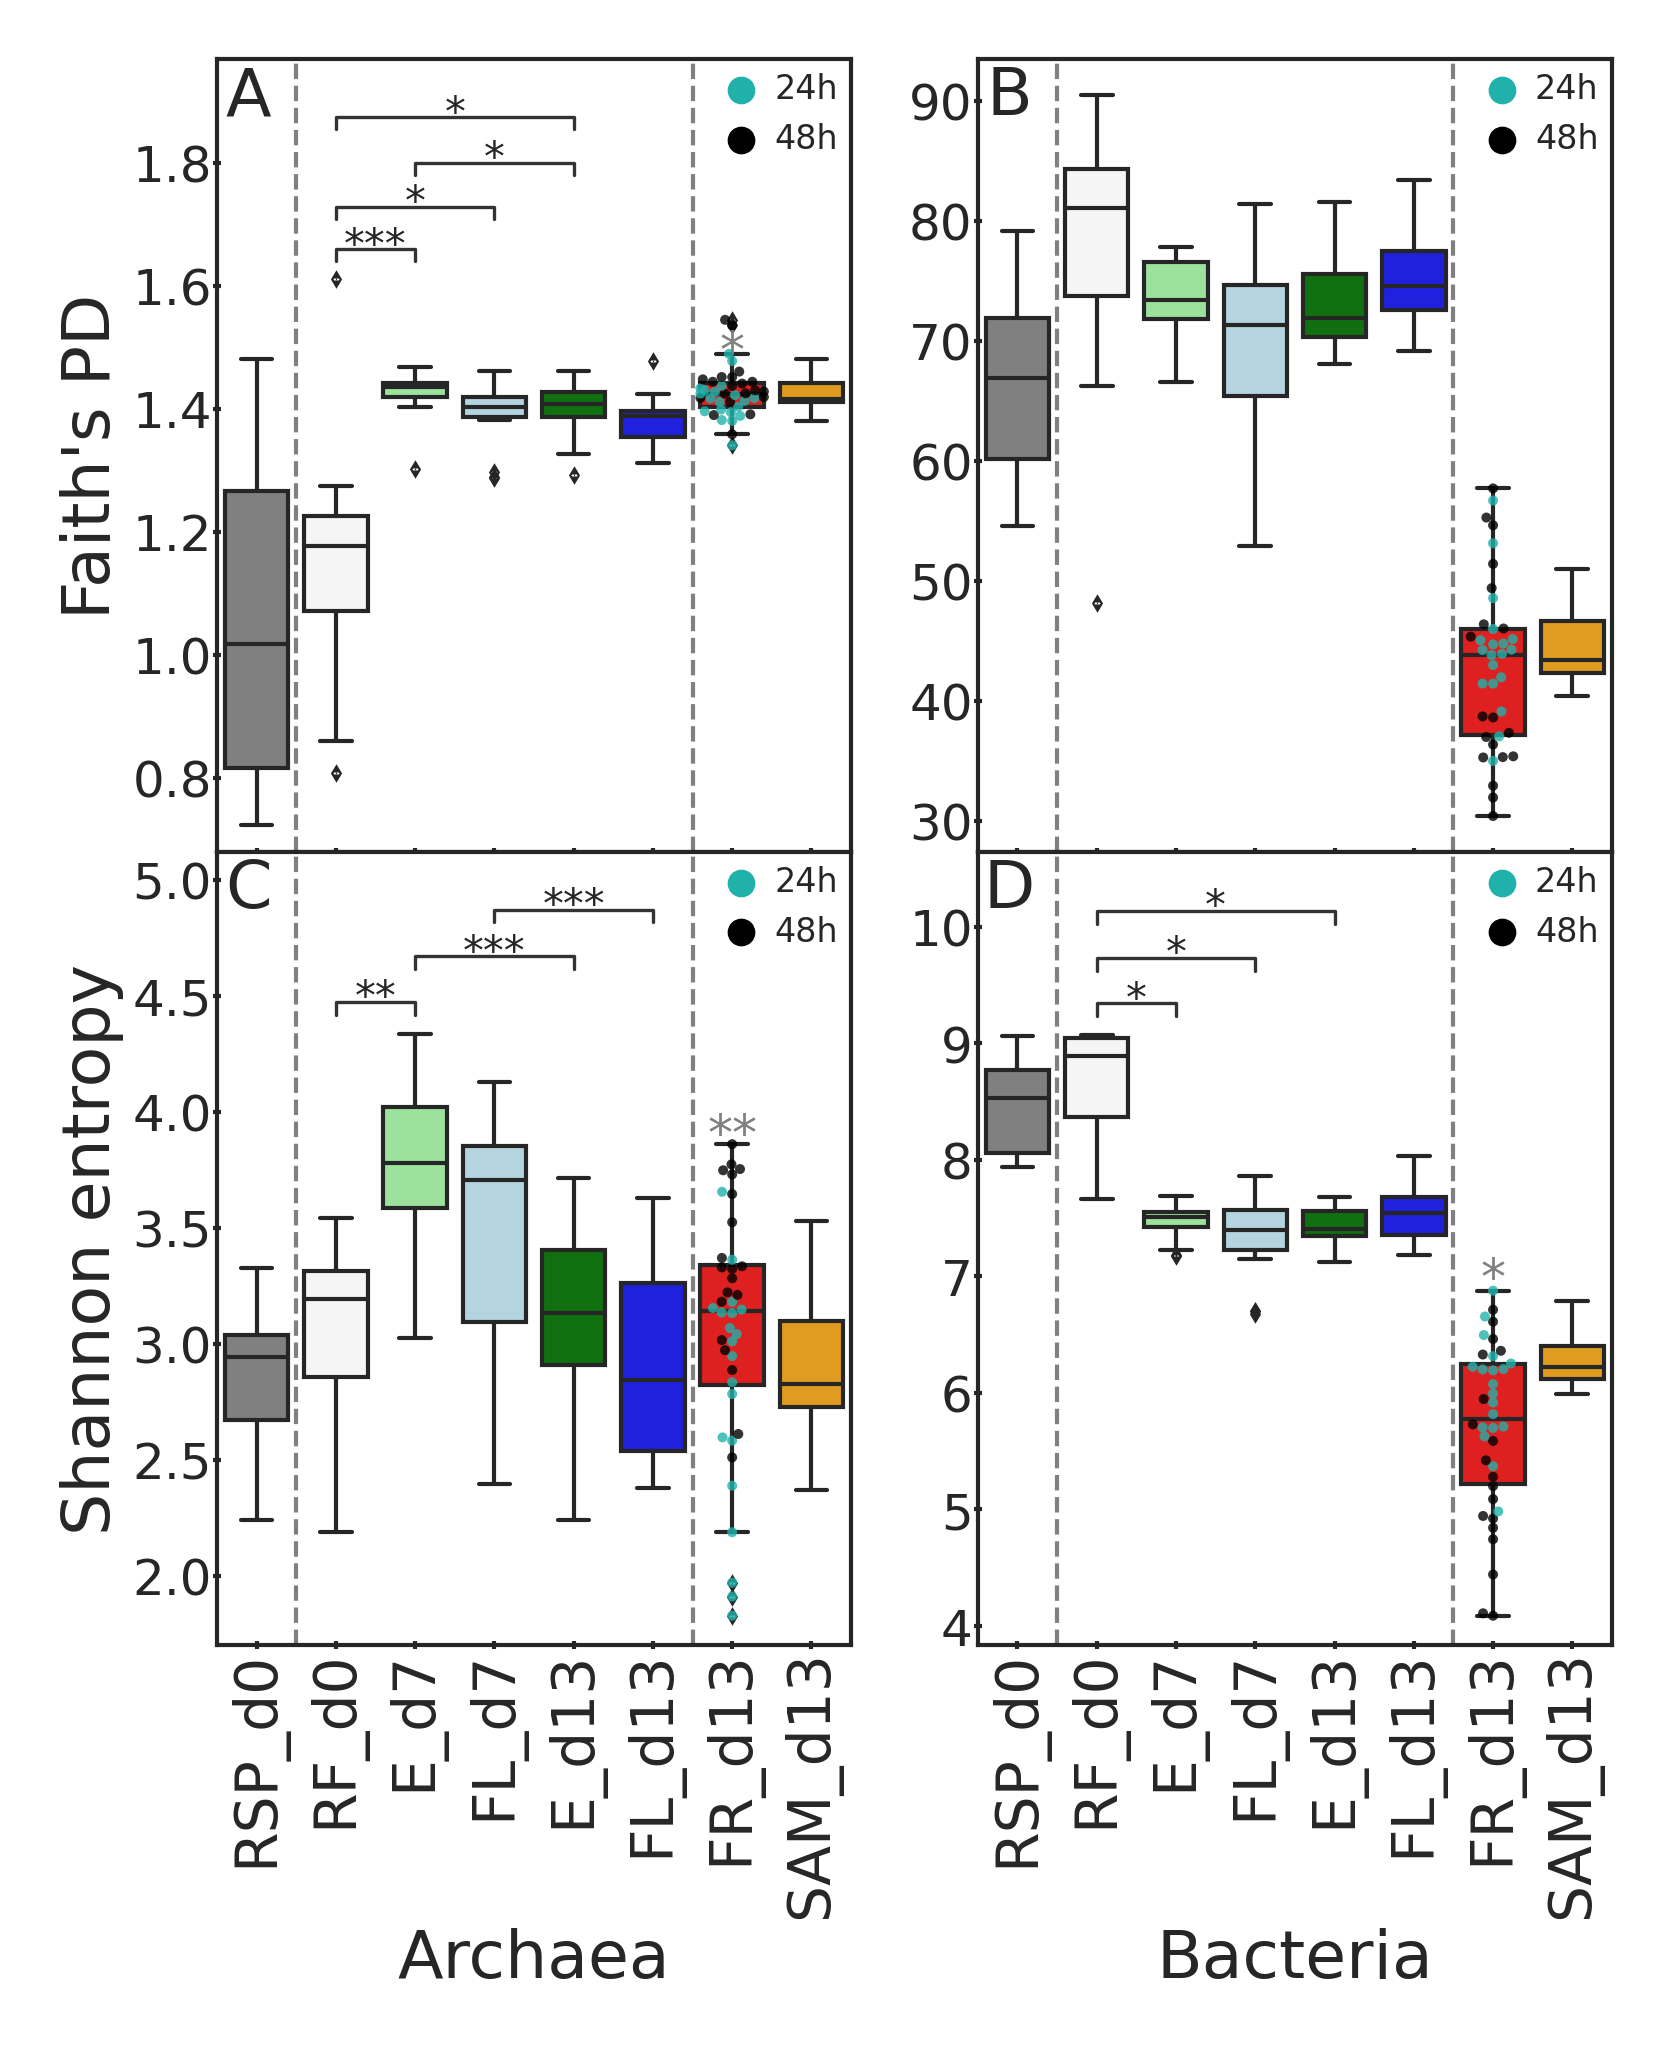

In [42]:
groups = [['RSP_d0','RF_d0','E_d7','FL_d7','E_d13','FL_d13'],['FR_d13','SAM_d13']]
order = groups[0]+groups[1]
cdict = {'RF_d0':'whitesmoke','RSP_d0':'grey','E_d7':'lightgreen','FL_d7':'lightblue',
         'E_d13':'green','FL_d13':'blue','FR_d13':'red','SAM_d13':'orange'}
hours = {'24h':'lightseagreen','48h':'black'}

fig,axes = plt.subplots(2,2,dpi=600,figsize=(3,3.5),gridspec_kw={'hspace':0,})
axs,i = [[n,m] for n in range(2) for m in range(2)],0
plt.rcParams['axes.linewidth'] = .5 #adjust line width
include = [('RF_d0','E_d7'),('RF_d0','FL_d7'),('RF_d0','E_d13'),('RF_d0','FL_d13'),
           ('E_d7','E_d13'),('FL_d7','FL_d13'),('FR_d13','SAM_d13')]
include = [set(sub) for sub in include]
for alp in alphas:
  for dom in domens:
    ax, i = axes[axs[i][0]][axs[i][1]], i+1
    alpha = pd.read_csv('rstc_2019_%s/Results/Core-metrics/alpha.tsv'%dom,sep='\t',index_col=0)

    data = alpha.copy()
    bp=sns.boxplot(x='BS_Day',y=alp,data=data,ax=ax,linewidth=0.5,fliersize=0.2,palette=cdict,order=order)
    swarm = data.loc[data.Day_hour!='not_appl'].copy()
    if not swarm.empty:
      swarm.Day_hour = swarm.Day_hour.str[-2:]+'h'
      sns.swarmplot(x='BS_Day',y=alp,data=swarm,hue='Day_hour',ax=ax,size=1.2,order=order,palette=hours,alpha=.8)
      ax.legend(loc=0,borderaxespad=0,handletextpad=0,fontsize=4,frameon=False,markerscale=0.3)
      kw,phoc1 = kw_dunn(swarm,'Day_hour',alp,pairwise=False)
      ast = '*'
      if kw[1] <= 0.0001: ast = '****'
      if kw[1] <= 0.001: ast = '***'
      if kw[1] <= 0.01: ast = '**'
      if kw[1] <= 0.05:
        whishi = mpl.cbook.boxplot_stats(swarm[alp])[0]['whishi'] #get whiskers
        ax.text(6,whishi-0.02,ast,size=6,ha='center',color='grey')
    ax.tick_params(axis='both',labelsize=6,length=1,pad=.1,width=.5,direction='inout')
    ax.tick_params(axis='x',labelsize=7,labelrotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    [ax.axvline(x=ind,c='grey',lw=.5,ls='--') for ind in [.5,5.5]]
    ax.text(.05,.93,'ABCD'[i-1],ha='center',fontsize=8,transform=ax.transAxes)
    #if alp == 'faith_pd':ax.text(.05,.94,g,size=8,transform=ax.transAxes,horizontalalignment='left')
    ax.set_xlabel(domens[dom],fontsize=8,labelpad=1)
    if dom == 'arc': ax.set_ylabel(alphas[alp],fontsize=8,labelpad=1)
    ax.set_xlim(-.5,len(order)-.5)
    # Statistics
    summary = pd.read_csv('Figures/Taxa_pairwise/Alpha_BS_Day_%s.tsv'%dom,sep='\t',index_col=0)
    summ = summary.loc[(summary.Metric==alp)&(summary.q<=.05)]
    qs = {(summ.loc[ind,'Group1'],summ.loc[ind,'Group2']):summ.loc[ind,'q'] for ind in summ.index}
    qs = {k:v for k,v in qs.items() if set(k) in include}
    if len(qs) == 0: continue
    x,y = 'BS_Day',alp
    add_stat_annotation(ax,x=x,y=y,box_pairs=list(qs.keys()),pvalues=list(qs.values()),line_height=0.02,\
                        data=data,fontsize=5,loc='inside',perform_stat_test=False,order=order,\
                        text_offset=-2,line_offset=.02,line_offset_to_box=0.03,text_format='star',linewidth=0.4)
    ax.set_ylim(auto=True)
    #ax.set_ylim(top=11)
      
fig.align_labels()
plt.savefig('Figures/Alpha-byType.png',bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

d13h24 v.s. d13h48: Custom statistical test, P_val:2.845e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

d13h24 v.s. d13h48: Custom statistical test, P_val:7.215e-04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

d13h24 v.s. d13h48: Custom statistical test, P_val:2.552e-02


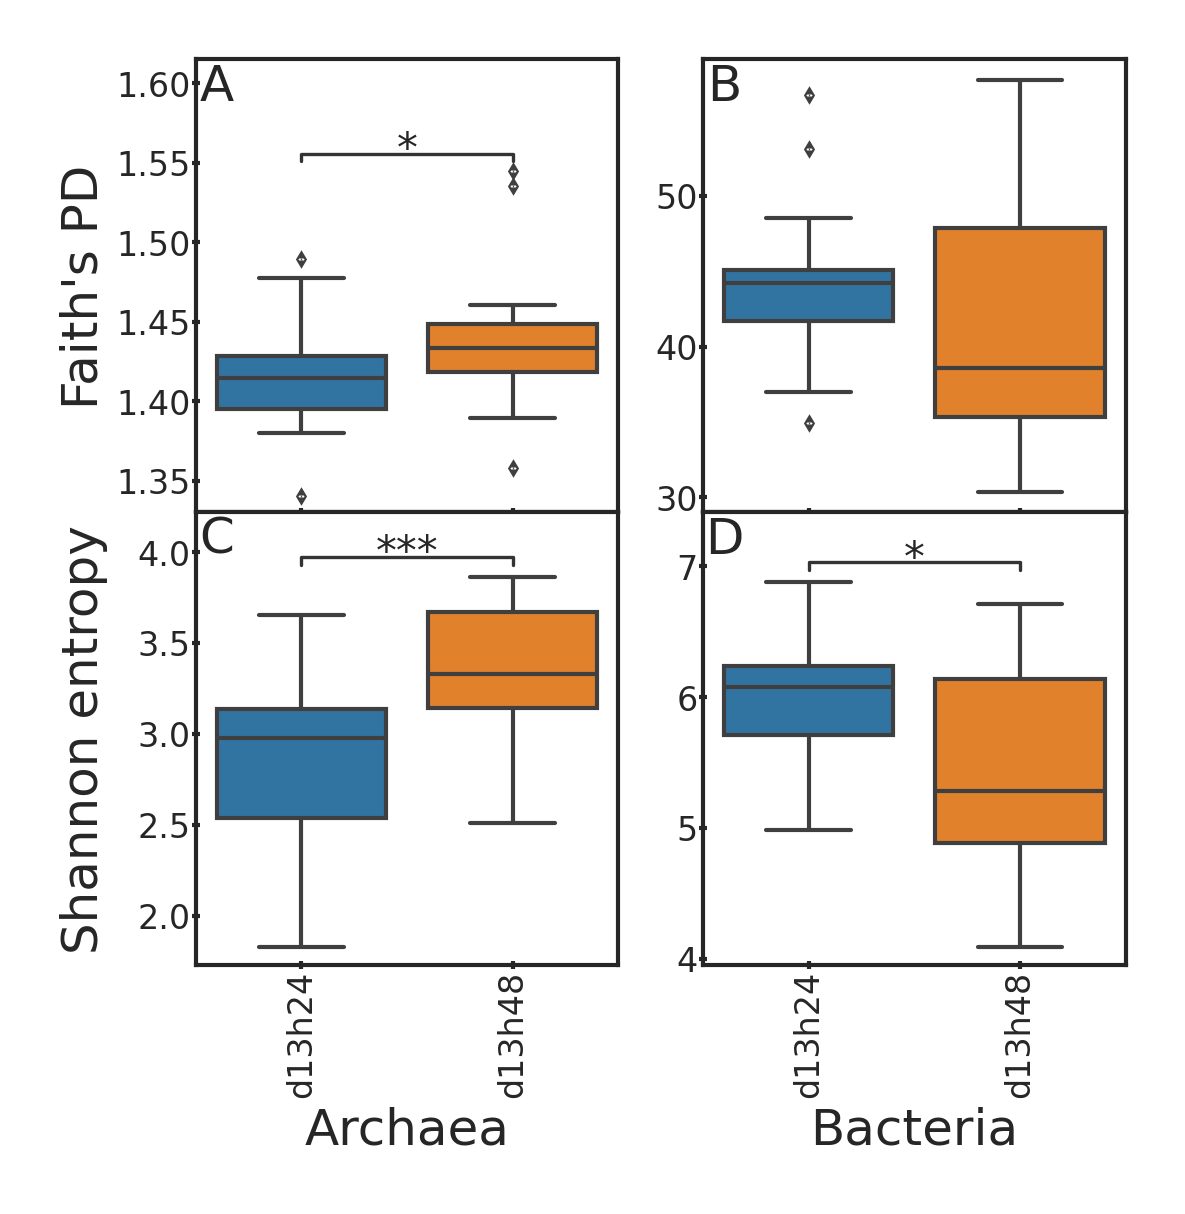

In [23]:
cdict = {'RF_d0':'whitesmoke','RSP_d0':'grey','E_d7':'lightgreen','FL_d7':'lightblue',
         'E_d13':'green','FL_d13':'blue','FR_d13':'red','SAM_d13':'orange'}
hours = {'24h':'lightseagreen','48h':'black'}

fig,axes = plt.subplots(2,2,dpi=600,figsize=(2,2),gridspec_kw={'hspace':0,})
axs,i = [[n,m] for n in range(2) for m in range(2)],0
plt.rcParams['axes.linewidth'] = .5 #adjust line width

for alp in alphas:
  for dom in domens:
    ax, i = axes[axs[i][0]][axs[i][1]], i+1
    alpha = pd.read_csv('rstc_2019_%s/Results/Core-metrics/alpha.tsv'%dom,sep='\t',index_col=0)
    swarm = alpha.loc[alpha.Day_hour!='not_appl'].copy()
    sns.boxplot(x='Day_hour',y=alp,data=swarm,ax=ax,linewidth=0.5,fliersize=0.2)

    ax.tick_params(axis='both',labelsize=4,length=1,pad=.1,width=.5,direction='inout')
    ax.tick_params(axis='x',labelsize=4,labelrotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.text(.05,.91,'ABCD'[i-1],ha='center',fontsize=6,transform=ax.transAxes)
    ax.set_xlabel(domens[dom],fontsize=6,labelpad=1)
    if dom == 'arc': ax.set_ylabel(alphas[alp],fontsize=6,labelpad=1)
    # Statistics
    qs = {}
    kw,phoc = kw_dunn(swarm,'Day_hour',alp,pairwise=True)
    if kw[1] <= 0.05:
      for j,q in enumerate(phoc['q']):
        if q <= 0.05:
          qs.update({(phoc.iloc[j]['Group1'],phoc.iloc[j]['Group2']):q})
    if len(qs) == 0: continue
    x,y = 'Day_hour',alp
    add_stat_annotation(ax,x=x,y=y,box_pairs=list(qs.keys()),pvalues=list(qs.values()),line_height=0.02,\
                        data=swarm,fontsize=5,loc='inside',perform_stat_test=False,\
                        text_offset=-2,line_offset=.02,line_offset_to_box=0.03,text_format='star',linewidth=0.4)
    ax.set_ylim(auto=True)
      
fig.align_labels()
plt.savefig('Figures/Alpha-byType_hourstest.png',bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Trt1 v.s. Trt3: Custom statistical test, P_val:4.759e-02
Trt1 v.s. Trt4: Custom statistical test, P_val:2.989e-02
Trt1 v.s. Trt5: Custom statistical test, P_val:2.989e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Trt1 v.s. Trt3: Custom statistical test, P_val:4.025e-02
Trt1 v.s. Trt4: Custom statistical test, P_val:3.580e-02
Trt1 v.s. Trt5: Custom statistical test, P_val:1.250e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Trt2 v.s. Trt4: Custom statistical test, P_val:4.025e-02
Trt1 v.s. Trt4: Custom statistical test, P_val:1.250e-02
Trt1 v.s. Trt5: Custom statistical test, P_val:4.025

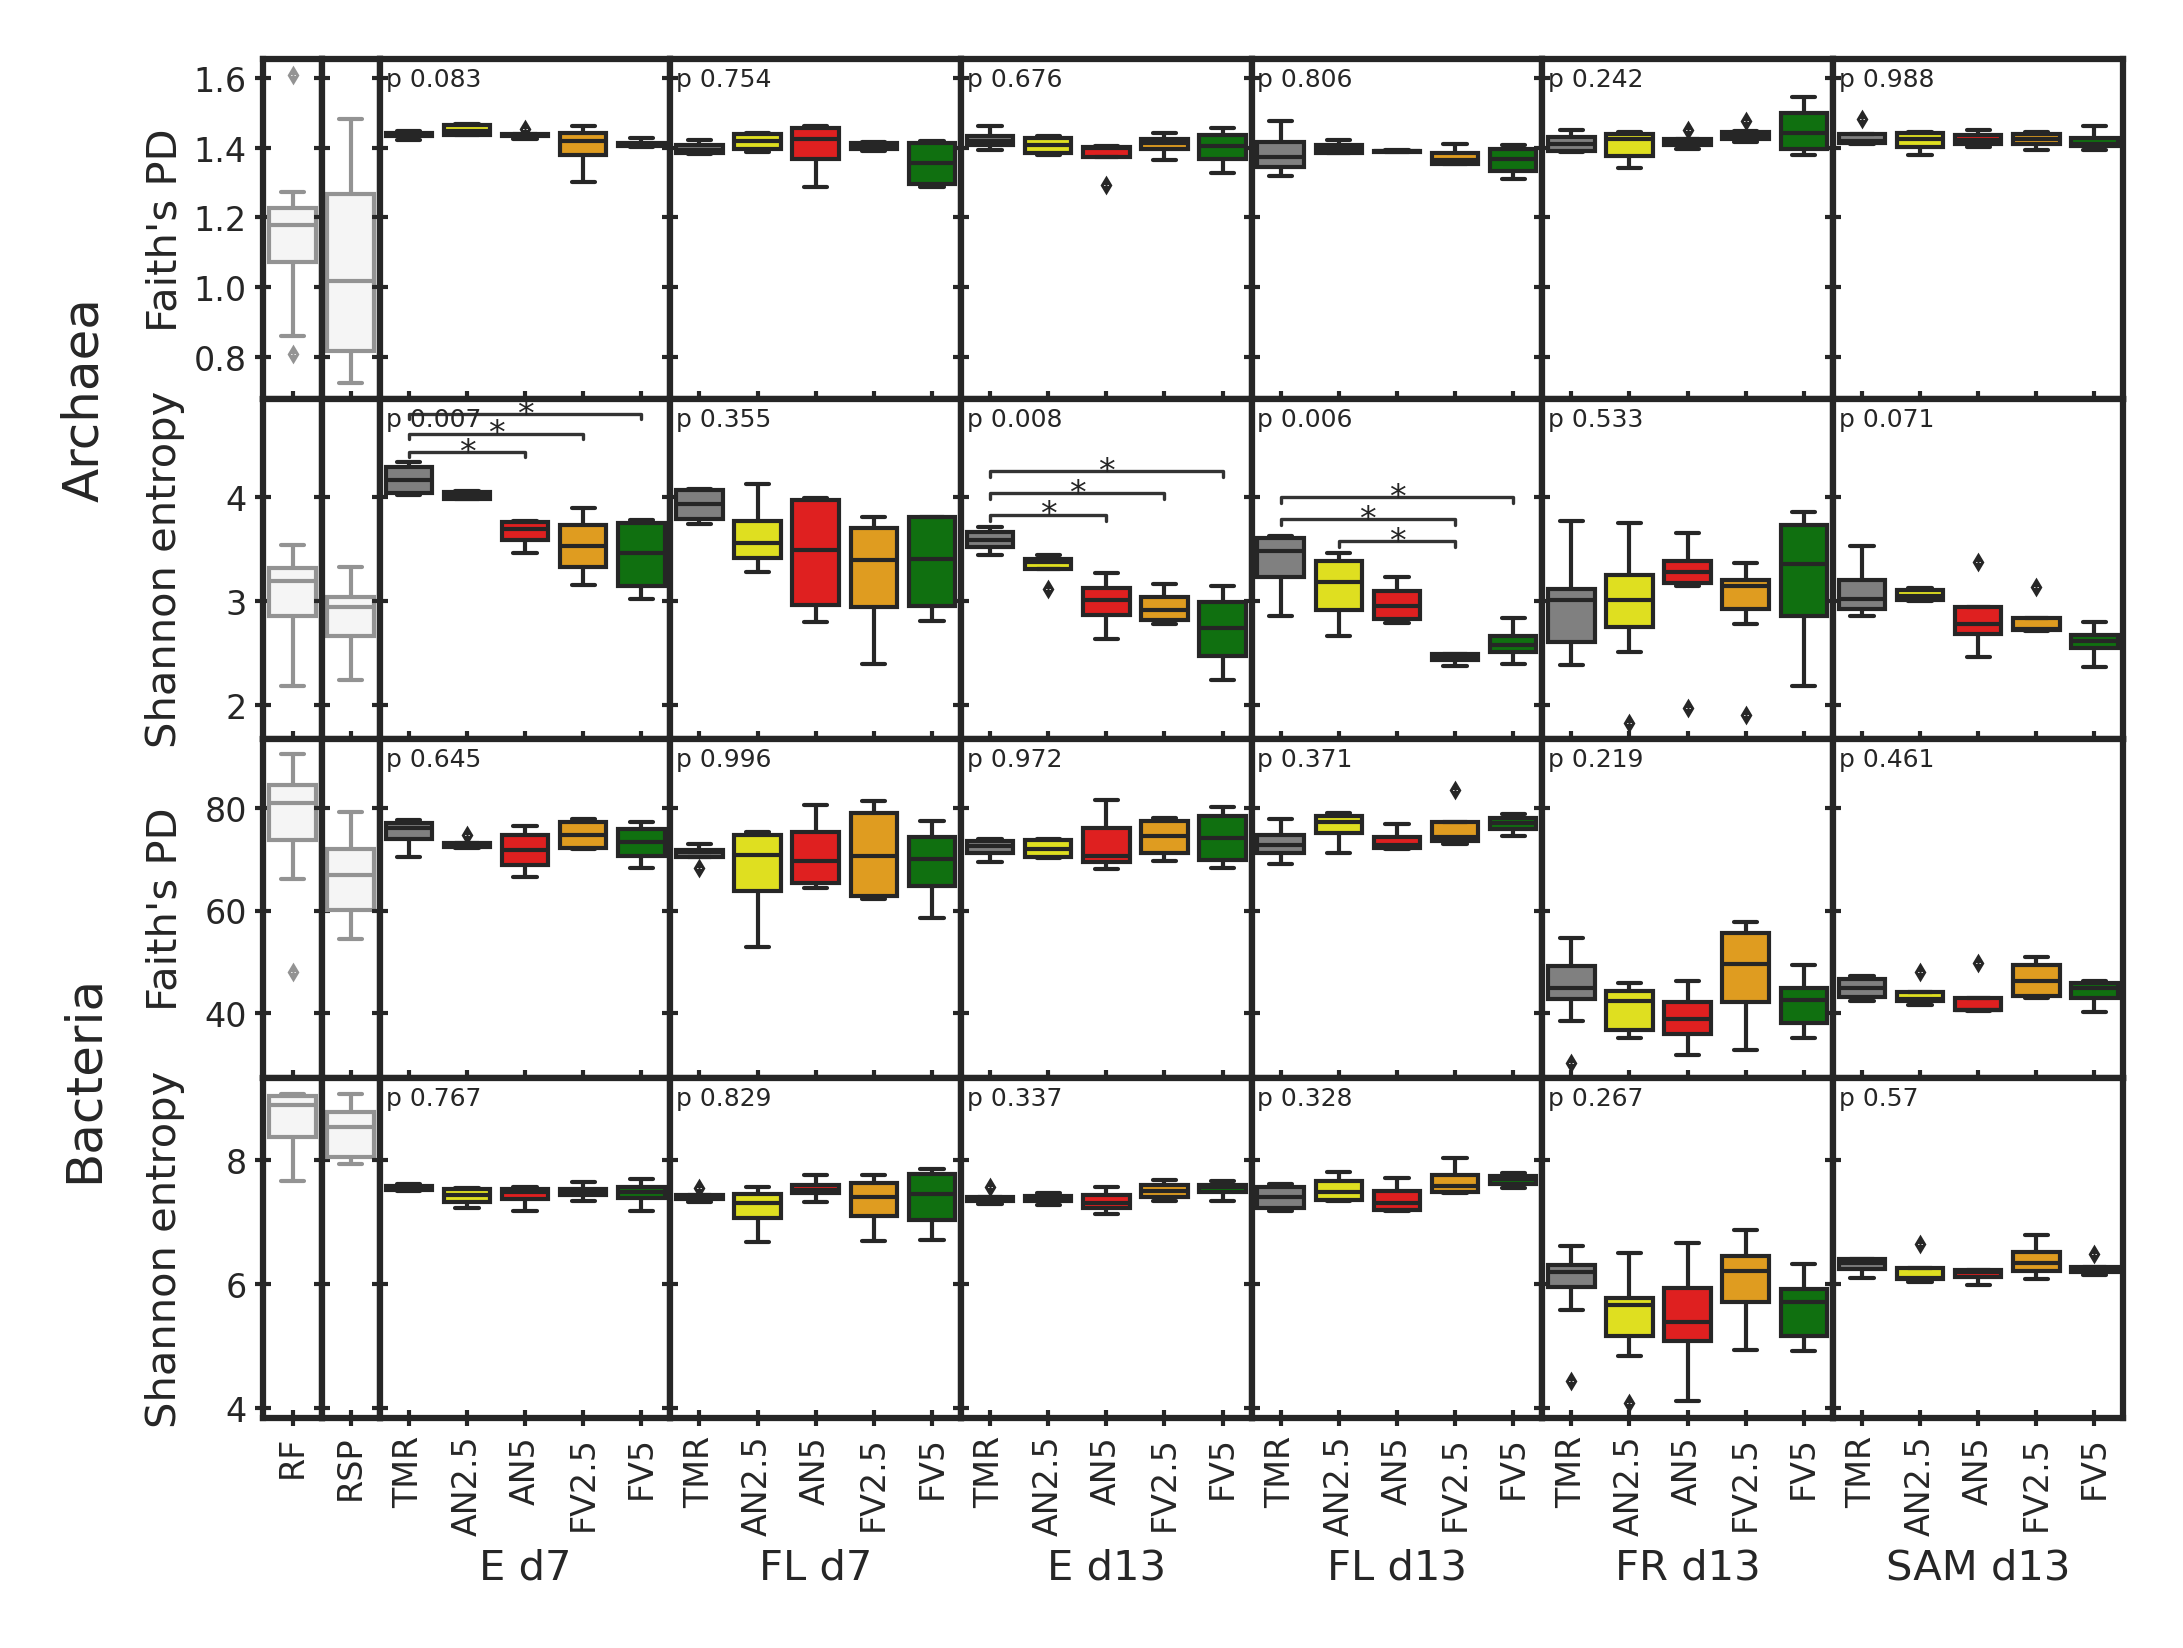

In [47]:
plt.rcParams["axes.linewidth"] = .75

names = {'Trt1':'TMR','Trt2':'AN2.5','Trt3':'AN5','Trt4':'FV2.5','Trt5':'FV5',}
groups = meta.BS_Day.unique()
ratios = [len(meta.loc[meta.BS_Day==g].Treatment.unique()) for g in groups]
cdict = {'Trt1':'grey','Trt2':'yellow','Trt3':'red','Trt4':'orange',\
         'Trt5':'green','Trt6':'blue','not_appl':'whitesmoke'}

fig, axes = plt.subplots(len(alphas)*2,len(groups),dpi=600,figsize=(4,3),sharey='row',sharex='col',\
    gridspec_kw={'hspace':0,'wspace':0,'width_ratios':ratios})
axs,i = [[n,m] for n in range(len(alphas)*2) for m in range(len(groups))],0

for dom in domens:
  alpha = pd.read_csv('rstc_2019_%s/Results/Core-metrics/alpha.tsv'%dom,sep='\t',index_col=0)
  for alp in alphas:
    for g in groups:
      data = alpha.loc[(alpha.BS_Day==g)].copy()
      order = [c for c in cdict.keys() if c in data.Treatment.tolist()]
      ax, i = axes[axs[i][0]][axs[i][1]], i+1
      sns.boxplot(x='Treatment',y=alp,data=data,ax=ax,linewidth=0.5,fliersize=0.3,palette=cdict,order=order)
      ax.tick_params(axis='both',labelsize=4,length=2,pad=1,width=0.5,direction='inout')
      ax.tick_params(axis='x',labelrotation = 90)
      ax.set_ylabel('')
      ax.set_xlabel('')
      if g == groups[0]: 
        ax.set_ylabel(alphas[alp],fontsize=5,labelpad=1)
        if alp == 'faith_pd':
          ax.text(-3.5,0,domens[dom],va='center',fontsize=6,rotation='vertical',transform=ax.transAxes)
      if alp == 'shannon_entropy' and dom == 'bac' and g not in groups[:2]: 
        ax.set_xlabel(g.replace('_',' '),fontsize=5,labelpad=1.5)
      labels = [item.get_text() for item in ax.get_xticklabels()]
      labels = [names[item] if 'not_appl' not in item else g.split('_')[0] for item in labels]
      ax.set_xticklabels(labels)
      ax.set_ylim(auto=True)
      # Statistics
      if g in groups[:2]: continue
      qs = {}
      kw,phoc = kw_dunn(data.copy(),'Treatment',alp,pairwise=True)
      ax.text(.02,.92,'p '+str(round(kw[1],3)),size=3,transform=ax.transAxes,ha='left')
      if kw[1] <= 0.05:
        for j,q in enumerate(phoc['q']):
          if q <= 0.05:
            qs.update({(phoc.iloc[j]['Group1'],phoc.iloc[j]['Group2']):q})
      if len(qs) == 0: continue
      x,y = 'Treatment',alp
      order_st = data.Treatment.unique().tolist()
      add_stat_annotation(ax,x=x,y=y,box_pairs=list(qs.keys()),pvalues=list(qs.values()),line_height=0.02,\
                          data=data,fontsize=4,loc='inside',perform_stat_test=False,order=order_st,\
                          text_offset=-2,line_offset=.005,line_offset_to_box=0.02,text_format='star',linewidth=0.4)

fig.align_labels()
plt.savefig('Figures/Alpha-byTreatments.png',bbox_inches='tight')

# BIPLOTS

In [48]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from scipy.spatial.distance import euclidean
%matplotlib inline

sns.set_style("ticks")
plt.rcParams["axes.linewidth"] = 1
def parse_biplot(qza): ### Unzipping qza biplots
  a = !unzip $qza
  digest = a[1].split('/')[0].replace('  inflating: ','')
  inf = digest + '/data/ordination.txt'
  lines = open(inf,'r').readlines()
  Eigvals = [float(i) for i in lines[1].rstrip().split('\t')]
  Proportion = [float(i) for i in lines[4].rstrip().split('\t')]
  bpl_skipr = 7
  bpl_skipf = len(open(inf,'r').read().split('Site')[1].splitlines()) + 1
  pca_skipr = len(open(inf,'r').read().split('Site')[0].splitlines()) + 1
  pca_skipf = 4
  pcoa = pd.read_csv(inf,index_col=0,skiprows=pca_skipr,skipfooter=pca_skipf,header=None,sep='\t',engine='python')
  biplot = pd.read_csv(inf,index_col=0,skiprows=bpl_skipr,skipfooter=bpl_skipf,header=None,sep='\t',engine='python')
  !rm -r $digest
  return  pcoa, biplot, Eigvals, Proportion

def get_arrow_coords(axis,axis2,num,biplot): ### Geting coordinats for arrows
  arrow_data = []
  origin = np.zeros_like(biplot.columns)
  biplot['importance'] = biplot.apply(euclidean, axis=1, args=(origin,))
  biplot.sort_values('importance', inplace=True, ascending=False)
  for taxon in biplot.index.tolist()[:num].copy():
    arrow_data.append([taxon,biplot.at[taxon,axis]/2,biplot.at[taxon,axis2]/2])
  return arrow_data

def distance_matrix(qza):
  a = !unzip $qza
  digest = a[1].split('/')[0].replace('  inflating: ','')
  inf = digest + '/data/distance-matrix.tsv'
  matrix = pd.read_csv(inf,sep='\t',index_col=0)
  !rm -r $digest
  return matrix

diversity = {'jaccard':'Jaccard','bray_curtis':'Bray-Curtis'}
domens = {'arc':'Archaea','bac':'Bacteria'}

## All sample-types by treatments

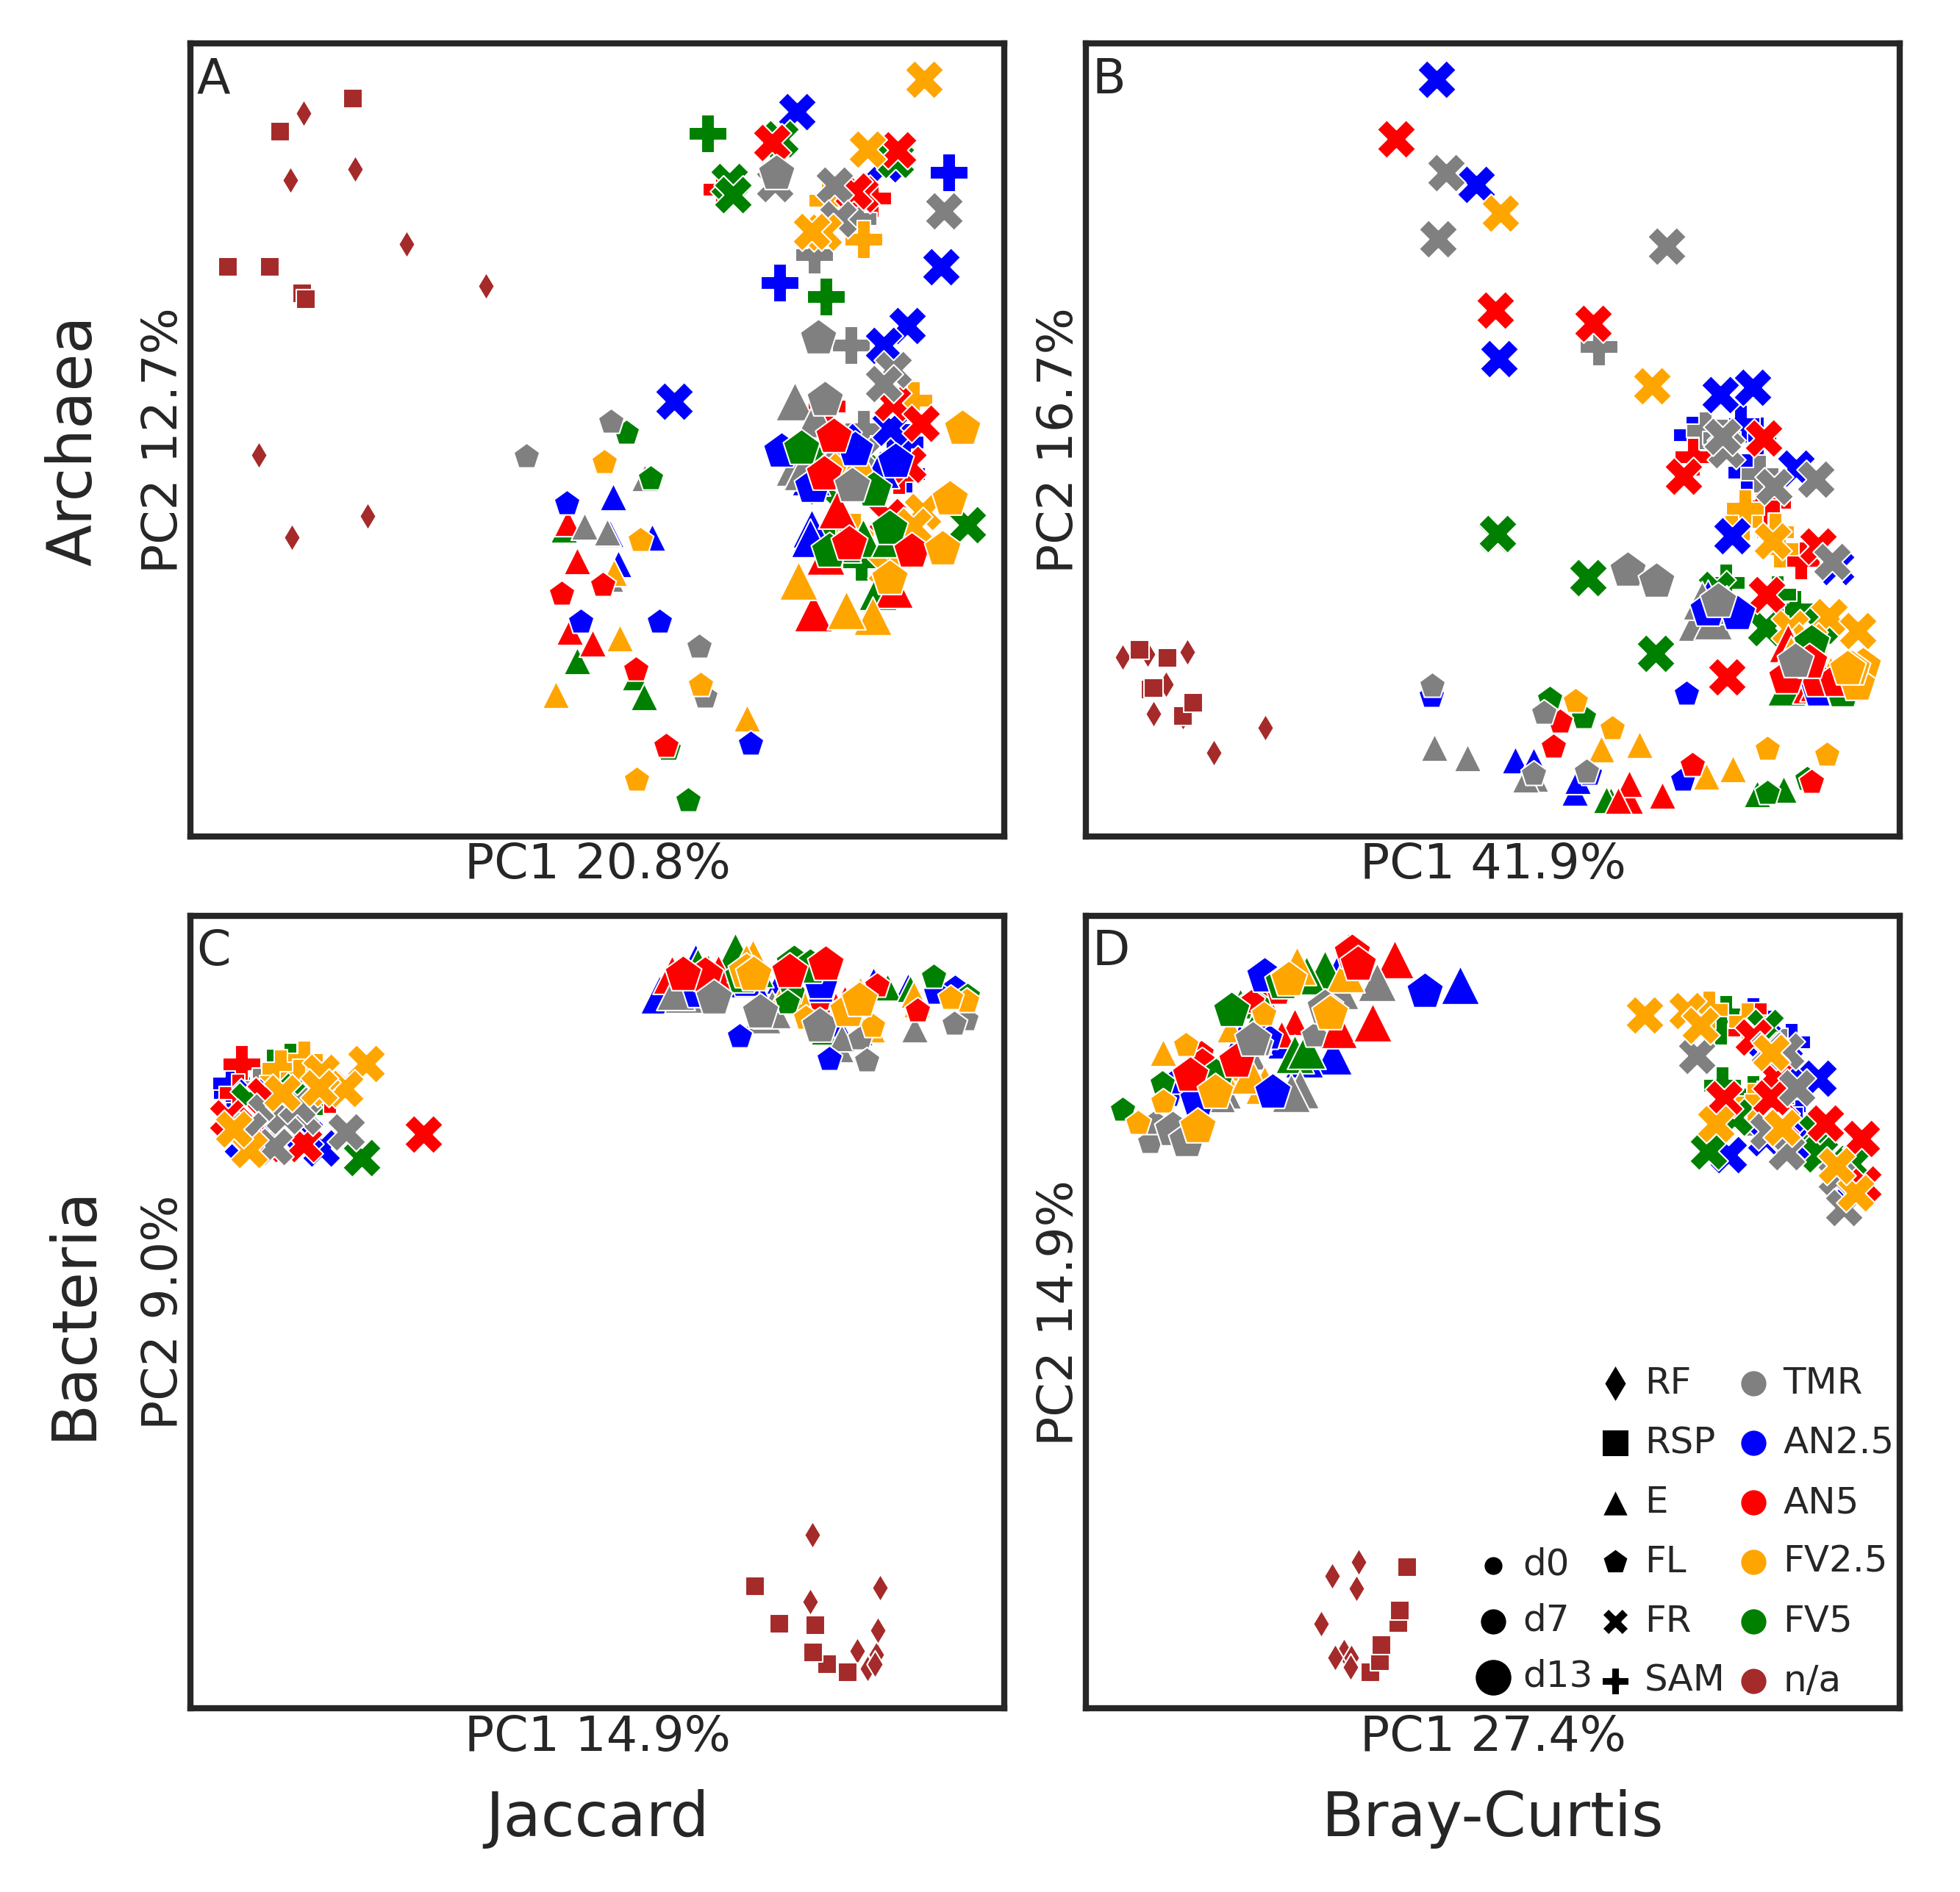

In [49]:
names = {'Trt1':'TMR','Trt2':'AN2.5','Trt3':'AN5','Trt4':'FV2.5','Trt5':'FV5','not_appl':'n/a'}
mdict = {'RF':'d', 'RSP':'s', 'E':'^', 'FL':'p', 'FR':'X', 'SAM':'P'}
sizes = {'d0':10,'d7':20,'d13':40}
cdict = {'Trt1':'grey','Trt2':'blue','Trt3':'red','Trt4':'orange','Trt5':'green','not_appl':'brown'}

def sub():
  for bs in set(pca_meta.BS):
    for d in set(pca_meta.Day):
      for trt in set(pca_meta.Treatment):
        c = cdict[trt]
        m = mdict[bs]
        s = sizes[d]
        df = ordin.loc[ordin.index.isin(pca_meta.loc[((pca_meta.BS==bs)&(pca_meta.Day==d)&(pca_meta.Treatment==trt))].index)]
        sns.scatterplot(x=x,y=y,data=df,ax=ax,color=c,marker=m,s=s,linewidth=0.25,legend=True)
        
# Creating a scatterplots 2*2*********************************************************
fig=plt.figure(figsize=(5,5),dpi=600)
gs = plt.GridSpec(2,2,wspace=0.1,hspace=0.1)
axes = [fig.add_subplot(ax) for ax in gs]
biplot_features = set()
z,i = 5,0 # Number of features to plot and axis numerator
x,y = 1,2 # axes to plot

for dom in domens:
  meta = pd.read_csv('rstc_2019_%s/Results/Core-metrics/alpha.tsv'%dom,sep='\t',index_col=0)
  for beta in diversity:
    ordin,biplot,Eigvals,Prop = parse_biplot('rstc_2019_%s/Results/Biplots/%s_biplot.qza'%(dom,beta))
    pca_meta = meta.loc[meta.index.isin(ordin.index)].copy()
    ax,i = axes[i],i+1
    sub() #plot scatterplot by function
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC%i %.1f%%'%(y,Prop[y-1]*100.0),fontdict={'fontsize':8},labelpad=.5)
    ax.set_xlabel('PC%i %.1f%%'%(x,Prop[x-1]*100.0),fontdict={'fontsize':8},labelpad=.8)
    ax.annotate("ABCD"[i-1],xy=(0,1),xycoords="axes fraction",xytext=(1,-8),textcoords="offset points",size=8)
    if beta == 'jaccard':
      ax.text(-.18,0.5,domens[dom],va='center',fontsize=10,transform=ax.transAxes,rotation='vertical')
    if dom == 'bac':
      ax.text(0.5,-.16,diversity[beta],ha='center',fontsize=10,transform=ax.transAxes)
    
# legend
axin1 = ax.inset_axes([0.62,0,0.4,0.5])
axin1.axis('off')
yax = .82
for trt in cdict: #colors
  sns.scatterplot(x=[0],y=[yax],marker='o',color=cdict[trt],ax=axin1,s=20,legend=False)
  axin1.text(.01,yax-.025,names[trt],fontdict={'size':6})
  yax = yax - 0.15
axin1.set_ylim(0,1)

axin2 = ax.inset_axes([0.45,0,0.4,0.5])
axin2.axis('off')
yax = .82
for m in mdict: #markers
  sns.scatterplot(x=[0],y=[yax],marker=mdict[m],color='black',ax=axin2,s=20,legend=False)
  axin2.text(.01,yax-.025,m,fontdict={'size':6})
  yax = yax - 0.15
axin2.set_ylim(0,1)

axin3 = ax.inset_axes([0.3,0,0.4,0.22])
axin3.axis('off')
yax = .82
for s in sizes: #sizes
  sns.scatterplot(x=[0],y=[yax],marker='o',color='black',ax=axin3,s=sizes[s],legend=False)
  axin3.text(.01,yax-.05,s,fontdict={'size':6})
  yax = yax - 0.32
axin3.set_ylim(0,1)

plt.savefig('Figures/Jaccard_Bray-Curtis_biplots.png', bbox_inches='tight')

# SCNIC

In [ ]:
!conda install -y -c bioconda -c conda-forge fastspar
!conda install -y -c bioconda -c conda-forge parallel
!pip install SCNIC
!pip install git+https://github.com/lozuponelab/q2-SCNIC.git
!qiime dev refresh-cache

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
\ 

In [52]:
pip install pandas==0.25

  Using cached pandas-0.25.0-cp36-cp36m-manylinux1_x86_64.whl (10.5 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-bio 0.5.6 requires pandas>=1.0.0, but you have pandas 0.25.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [80]:
pip install pandas -U

  Using cached pandas-1.1.5-cp36-cp36m-manylinux1_x86_64.whl (9.5 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.0
    Uninstalling pandas-0.25.0:
      Successfully uninstalled pandas-0.25.0
Note: you may need to restart the kernel to use updated packages.


In [54]:
# collapse table 
tabin = 'rstc_2019_arc/Data/Divided_tables/full-table.qza'
tab_6 = 'rstc_2019_arc/Data/Divided_tables/gen-table.qza'

!qiime taxa collapse \
  --i-table $tabin \
  --i-taxonomy rstc_2019_arc/Data/combo_taxonomy.qza \
  --p-level 6 \
  --o-collapsed-table $tab_6

Saved FeatureTable[Frequency] to: rstc_2019_arc/Data/Divided_tables/gen-table.qza


In [56]:
import pandas as pd
for dom in ['arc','bac']:
  outdir = 'rstc_2019_%s/Results/SCNIC'%dom
  !mkdir $outdir
  tabin = 'rstc_2019_%s/Data/Divided_tables/gen-table.qza'%dom
  tabex = outdir + '/scnic-table.qza'
  meta = 'rstc_2019_%s/metadata.tsv'%dom
  
  #create a new metadata for bacteria+archaea
  md = pd.read_csv(meta,sep='\t',index_col=0)
  md['NewID'] = 'AB'+md.index.str[1:]
  md.to_csv(meta,sep='\t')
  retain = md.loc[md.BS.isin(['E','FR','FL'])]
  retain.to_csv(outdir+'/retain.tsv',sep='\t')
  retain = outdir+'/retain.tsv'
  
  
  #Filter unnecessary sample-types
  !qiime feature-table filter-samples \
    --i-table $tabin \
    --m-metadata-file $retain \
    --o-filtered-table $tabex
  #filer by relative abundances
  !qiime feature-table filter-features-conditionally \
    --i-table $tabex \
    --p-abundance .01 \
    --p-prevalence .05 \
    --o-filtered-table $tabex
  #Rename samples for SCNIC tables
  !qiime feature-table rename-ids \
    --i-table $tabex \
    --m-metadata-file $meta \
    --m-metadata-column NewID \
    --p-axis 'sample' \
    --p-strict \
    --o-renamed-table $tabex
  #relative tables for heatmaps
  tabin = 'rstc_2019_%s/Data/Relative_tables/gen-relative_table.qza'%dom
  tabex = outdir + '/scnic-rel-table.qza'
  !qiime feature-table rename-ids \
    --i-table $tabin \
    --m-metadata-file $meta \
    --m-metadata-column NewID \
    --p-axis 'sample' \
    --p-strict \
    --o-renamed-table $tabex  

Saved FeatureTable[Frequency] to: rstc_2019_arc/Results/SCNIC/scnic-table.qza
Saved FeatureTable[Frequency] to: rstc_2019_arc/Results/SCNIC/scnic-table.qza
Saved FeatureTable[Frequency] to: rstc_2019_arc/Results/SCNIC/scnic-table.qza
Saved FeatureTable[RelativeFrequency] to: rstc_2019_arc/Results/SCNIC/scnic-rel-table.qza
mkdir: cannot create directory ‘rstc_2019_bac/Results/SCNIC’: File exists
Saved FeatureTable[Frequency] to: rstc_2019_bac/Results/SCNIC/scnic-table.qza
Saved FeatureTable[Frequency] to: rstc_2019_bac/Results/SCNIC/scnic-table.qza
Saved FeatureTable[Frequency] to: rstc_2019_bac/Results/SCNIC/scnic-table.qza
Saved FeatureTable[RelativeFrequency] to: rstc_2019_bac/Results/SCNIC/scnic-rel-table.qza


In [57]:
import pandas as pd

!mkdir SCNIC

#new metadata
meta = pd.read_csv('rstc_2019_arc/metadata.tsv',sep='\t',index_col=0)
meta.set_index('NewID',inplace=True)
meta.index.rename('#SampleID',inplace=True)
meta = meta.loc[meta.BS.isin(['E','FR','FL'])]
meta.to_csv('SCNIC/metadata.tsv',sep='\t')

# merge arc and bac tables
tab1 = 'rstc_2019_arc/Results/SCNIC/scnic-table.qza'
tab2 = 'rstc_2019_bac/Results/SCNIC/scnic-table.qza'
table = 'SCNIC/AB-scnic-table.qza'

!qiime feature-table merge \
  --i-tables $tab1 $tab2 \
  --p-overlap-method 'error_on_overlapping_feature' \
  --o-merged-table $table

#merge relative tables
tab1 = 'rstc_2019_arc/Results/SCNIC/scnic-rel-table.qza'
tab2 = 'rstc_2019_bac/Results/SCNIC/scnic-rel-table.qza'
table = 'SCNIC/AB-rel-scnic-table.qza'

!qiime feature-table merge \
  --i-tables $tab1 $tab2 \
  --p-overlap-method 'error_on_overlapping_feature' \
  --o-merged-table $table

mkdir: cannot create directory ‘SCNIC’: File exists
Saved FeatureTable[Frequency] to: SCNIC/AB-scnic-table.qza
Saved FeatureTable[RelativeFrequency] to: SCNIC/AB-rel-scnic-table.qza


In [58]:
#filter out not assigned to genus level features
import pandas as pd
table = 'SCNIC/AB-scnic-table.qza'
!qiime tools export \
  --input-path $table \
  --output-path SCNIC/
!biom convert -i SCNIC/feature-table.biom -o SCNIC/feature-table.tsv --to-tsv 

biom = pd.read_csv('SCNIC/feature-table.tsv',sep='\t',skiprows=1,index_col=0)
biom = biom.loc[[i for i in biom.index if 'g__' in i],:]
biom.to_csv('SCNIC/feature-table.tsv',sep='\t')

#export relative table
table = 'SCNIC/AB-rel-scnic-table.qza'
!qiime tools export \
  --input-path $table \
  --output-path ./
!biom convert -i ./feature-table.biom -o SCNIC/rel-feature-table.tsv --to-tsv 
!rm ./feature-table.biom

Exported SCNIC/AB-scnic-table.qza as BIOMV210DirFmt to directory SCNIC/
Exported SCNIC/AB-rel-scnic-table.qza as BIOMV210DirFmt to directory ./


In [59]:
import pandas as pd
import numpy as np

def taxamod(taxa):
  if '|' in taxa.index[0]:
    taxa.index = taxa.index.str.replace('methanogenic','m').str.split('|').str[0]+'\\'+taxa.index.str.split('|').str[1].str[:4]
    return taxa
  else:
    tax_rep = {';__':'','[':'',']':'','.':'','/':'_',"'":'_',' ':'_','archaeon_enrichment':'a_e','YAB2003':'uncl(YAB2003)',
      'uncultured_rumen':'uncl','uncultured_archaeon':'uncl','uncultured_euryarchaeote':'uncl','DNF00809':'uncl(DNF00809)',
      'uncultured_compost':'uncl','_archaeon':'uncl','unidentified':'unid','unid_rumen':'unid','RF39':'uncl(RF39)',
      'uncultured_bacterium':'uncl','uncultured':'uncl','rumen_bacterium':'uncl','p-251-o5':'uncl(p-251-o5)','group':'gr',
      '_gr':'','F082':'uncl(F082)','WPS-2':'uncl(WPS-2)','\(Marine_B\)':'','Family_XIII_AD3011':'uncl(Family_XIII_AD3011)',
      'WCHB1.41':'uncl(WCHB1.41)','UCG.002':'uncl(UCG.002)','NK4A214':'uncl(NK4A214)','X0319.6G20':'uncl(X0319.6G20)',
      'NC2004':'uncl(NC2004)','SAR324_clade':'uncl(SAR324-clade)','UCG-006':'uncl(UCG-006)','SN8':'uncl(SN8)','RF16':'uncl(RF16)',
      'FD2005':'uncl(FD2005)','vadinHA49':'uncl(vadinHA49)','Clostridium_sensu_stricto_1':'Clostridium(sensu_stricto_1)',
      'UCG-014':'uncl(UCG-014)','UCG-014':'uncl(UCG-014)','UCG-010':'uncl(UCG-010)','UCG-004':'uncl(UCG-004)','Ga6A1':'uncl(Ga6A1)',
      'vadinBE97':'uncl(vadinBE97)','vadinBB60':'uncl(vadinBB60)','XBB1006':'uncl(XBB1006)','FE2018':'uncl(FE2018)',
      'UCG-005':'uncl(UCG-005)','UCG-007':'uncl(UCG-007)','UCG-009':'uncl(UCG-009)','R-7':'uncl(R-7)','UCG-003':'uncl(UCG-003)',
      'RC9_gut':'uncl(RC9_gut)','probable_genus_10':'uncl(gen10)','0319-6G20':'uncl(0319-6G20)','AC2044':'uncl(AC2044)',
      'FCS020':'uncl(FCS020)','Family_XIII_UCG-001':'uncl(Family_XIII_UCG001)','UCG-001':'uncl(UCG-001)','NK3A20':'uncl(NK3A20)',
      'Lineage_IV':'uncl(Lineage_IV)'}
    taxa['Taxon2'] = taxa.index
    for key in tax_rep.keys():
      taxa['Taxon2'] = taxa['Taxon2'].str.replace(key, tax_rep[key])

    #dealing with uncultured taxa to provide additional information
    taxa['Combo'] =  taxa['Taxon2'].str.split("__").str[-1].str.split(";").str[-1]
    for x in ['uncl','unid_methanogen','unid','methanogenic_uncl','uncl_methanogenic_uncl','uncl(UCG-004)','uncl(X0319.6G20)',
              'uncl(DNF00809)','uncl(UCG-006)','uncl(NC2004)','uncl(RF39)','uncl(SN8)','uncl(FD2005)',
              'uncl(vadinHA49)','uncl(vadinBE97)','uncl(vadinBB60)','uncl(XBB1006)','uncl(FE2018)','uncl(UCG-005)','uncl(UCG-007)',
              'uncl(UCG-009)','uncl(R-7)','uncl(UCG-003)','uncl(RF16)','uncl(Ga6A1)','uncl(RC9_gut)','uncl(gen10)','uncl(0319-6G20)',
              'uncl(FCS020)','uncl(Family_XIII_UCG-001)','uncl(Lineage_IV)',]:
      taxa.loc[taxa['Combo'].str[:]==x,'Combo']=taxa['Taxon2'].str.split("__").str[-2].str.split(';').str[0]+'_'+x
    for n in range(3,6):
      for y in ['uncl_uncl','unid_uncl','uncl_unid','methanogenic_uncl','uncl(RF39)_uncl(RF39)',
                'uncl(vadinHA49)_uncl(vadinHA49)','uncl(0319-6G20)_uncl(0319-6G20)','uncl(vadinBE97)_uncl(vadinBE97)','unid_unid',]:
        taxa.loc[taxa.Combo.str[:]==y,'Combo']=taxa.Taxon2.str.split("__").str[-n].str.split(';').str[0]+'_'+y.split('_',1)[1]

    #add modified taxonomy information to feature hashes, separating them by '|'
    taxa.set_index('Combo',inplace=True)
    taxa.drop(['Taxon2'],axis=1,inplace=True)
    return taxa

In [60]:
import pandas as pd
import numpy as np
  
data = pd.read_csv('Project_Descriptions/Data Rusitec 2019.csv',sep='\t',skiprows=1)
data = data.replace('.',np.nan)
data['Grouped'] = 'Trt'+data.treatment.astype(str)+'_d'+data.day.astype(str)+'_HP'+data['heat pumpt'].astype(str)\
                  +'_r'+data.run.astype(str)+'_'+data.fermenter.astype(str)
data.set_index('Grouped',inplace=True)
data[data.columns] = data[data.columns].apply(lambda x: pd.to_numeric(x, errors='coerce'))
#data = data.copy().groupby(data.index).mean()
data = data.drop(['run','day','treatment','algae','dose','fermenter','heat pumpt'],axis=1)
for group in data.index:
  if 'd7' not in group and 'd13' not in group: continue
  for col in data.columns:
    # replace unsampled days by closest sampled day
    if np.isnan(float(data.loc[group,col])):
      if 'd7' in group:
        for d in range(8,14):
          if not np.isnan(float(data.loc[group.replace('d7','d%s'%d),col])):
            data.loc[group,col] = data.loc[group.replace('d7','d%s'%d),col]
            continue
      elif 'd13' in group:
        for d in reversed(range(7,14)):
          if not np.isnan(float(data.loc[group.replace('d13','d%s'%d),col])):
            data.loc[group,col] = data.loc[group.replace('d13','d%s'%d),col]
            continue
#display(data)
meta = pd.read_csv('SCNIC/metadata.tsv',sep='\t',index_col='#SampleID')
#meta = meta.loc[(meta.Day!='d0')&(meta.Day_hour!='d13h24')]
meta = meta.loc[(meta.Day!='d0')]
meta['Grouped'] = meta.Treatment+'_'+meta.Day+'_'+meta.Source+'_r'+meta.rstc_run.str[-1]+'_'+meta.Fermenter
for col in data.columns:
  for ind in data.index:
    meta.loc[meta.Grouped==ind,col] = data.loc[ind,col]
#display(meta)
biom = meta.drop([c for c in meta.columns if c not in data.columns],axis=1).T
biom.index.name = '#OTU ID'
feat = pd.read_csv('SCNIC/feature-table.tsv',sep='\t',index_col=0)
feat = feat.drop([c for c in feat.columns if c not in biom.columns],axis=1)
feat=taxamod(feat)
correlate = ['Tot_gas','CH4_p','CH4_ml','NH3N_d','Acetate_d','Propionate_d','IsoButyrate_d','Butyrate_d',\
             'IsoValerate_d','Valerate_d','Acetate_Propionate','VFA_d','ph']
biom = biom.loc[correlate,:]
biom.to_csv('SCNIC/measurements.tsv',sep='\t')
feat.to_csv('SCNIC/feature-table.tsv',sep='\t')
!biom convert -i SCNIC/measurements.tsv -o SCNIC/measurements.biom --table-type="OTU table" --to-hdf5
!biom convert -i SCNIC/feature-table.tsv -o SCNIC/feature-table.biom --table-type="OTU table" --to-hdf5

In [61]:
#correlate features (SparCC)
!mkdir SCNIC/Within_features
!SCNIC_analysis.py within -i SCNIC/feature-table.biom -o SCNIC/Within_features/ -m sparcc --sparcc_filter -a 'fdr_bh' --sparcc_p 1000

#correlate measurements (Spearman)
!mkdir SCNIC/Within_measurements
!SCNIC_analysis.py within -i SCNIC/measurements.biom -o SCNIC/Within_measurements/ -m spearman -a 'fdr_bh'

mkdir: cannot create directory ‘SCNIC/Within_features’: File exists
/home/meco/anaconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/SCNIC/correlation_analysis.py:77: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  table.to_dataframe().to_dense().to_csv(path.join(temp, 'otu_table.tsv'), sep='\t', index_label='#OTU ID')
Running SparCC iterations
	Running iteration: 1
	Running iteration: 2
	Running iteration: 3
	Running iteration: 4
	Running iteration: 5
	Running iteration: 6
	Running iteration: 7
	Running iteration: 8
	Running iteration: 9
	Running iteration: 10
	Running iteration: 11
	Running iteration: 12
	Running iteration: 13
	Running iteration: 14
	Running iteration: 15
	Running iteration: 16
	Running iteration: 17
	Running iteration: 18
	Running iteration: 19
	Running iteration: 20
	Running iteration: 21
	Running iteration: 22
	Running iteration: 23
	Running iteration: 24
	Running iteration: 25
	Running iteration: 26
	Running ite

In [62]:
#group data by modules for further analysis
!mkdir SCNIC/Modules_features
!SCNIC_analysis.py modules -i SCNIC/Within_features/correls.txt -o SCNIC/Modules_features/ \
--min_r .35 --table SCNIC/feature-table.biom

!biom convert -i SCNIC/Modules_features/collapsed.biom -o SCNIC/Modules_features/biom.tsv --to-tsv  

mkdir: cannot create directory ‘SCNIC/Modules_features’: File exists


In [64]:
# correlate by sample-types features and measurements
import pandas as pd
for kind in ['features','measurements']:
  if kind == 'features':
    biom_df = pd.read_csv('SCNIC/feature-table.tsv',sep='\t',index_col=0)
  else:
    biom_df = pd.read_csv('SCNIC/measurements.tsv',sep='\t',index_col=0)
  for bs in meta.BS.unique():
    outdir = 'SCNIC/'+bs
    !mkdir $outdir
    md = meta.loc[meta.BS==bs].copy()
    
    #filter biom files by bs
    biom_bs = biom_df.loc[:,md.index].copy()
    biom_bs.to_csv(outdir+'/%s.tsv'%kind,sep='\t')
    tsv = outdir+'/%s.tsv'%kind
    biom = outdir+'/%s.biom'%kind
    !biom convert -i $tsv -o $biom --table-type="OTU table" --to-hdf5
    
#perform SCNIC between    
for bs in meta.BS.unique():
  outdir = 'SCNIC/'+bs
  !SCNIC_analysis.py between -1 $outdir/features.biom -2 $outdir/measurements.biom -o $outdir/Between/ -m spearman 

mkdir: cannot create directory ‘SCNIC/FL’: File exists
mkdir: cannot create directory ‘SCNIC/E’: File exists
mkdir: cannot create directory ‘SCNIC/FR’: File exists
/home/meco/anaconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [65]:
from statsmodels.stats.multitest import multipletests

#group relative abundances to the same modules
biom_ra = taxamod(pd.read_csv('SCNIC/rel-feature-table.tsv',sep='\t',skiprows=1,index_col=0))
#modules = pd.read_csv('SCNIC/Modules_features/modules.txt',sep='\t',index_col=0,header=None)

#for ind_ra in biom_ra.index:
#  if ind_ra in modules.stack().tolist():
#    for ind_mo in modules.index:
#      if ind_ra in modules.loc[ind_mo,:].tolist():
#        biom_ra.loc[ind_ra,'module'] = ind_mo
#        continue
#  else:
#    biom_ra.loc[ind_ra,'module'] = ind_ra
#biom_ra.set_index('module',inplace=True)
#biom_ra = biom_ra.groupby(biom_ra.index).sum()
#biom_ra.index.tolist()

meta = pd.read_csv('SCNIC/metadata.tsv',sep='\t',index_col='#SampleID')
meta = meta.loc[(meta.Day!='d0')&(meta.Day_hour!='d13h24')]
summary = pd.DataFrame()
relabs  = pd.DataFrame()

for bs in meta.BS.unique():
  #summarise correlation data
  data = pd.read_csv('SCNIC/%s/Between/correls.txt'%bs,sep='\t')
  data = data.loc[(data.p > 0)]
  data.p_adj = multipletests(data.p,method='fdr_bh')[1] 
  data = data.loc[(data.p_adj <= 0.05)&((data.r >= 0.3)|(data.r <= -0.3))]
  data['stype'] = bs 
  summary = pd.concat([summary,data],ignore_index=True)
  #store relative abundances
  #relab = pd.read_csv('SCNIC/%s/features.tsv'%bs,sep='\t',index_col=0)
  #relab.index = relab.index+'_'+bs
  ra = pd.DataFrame()
  md_bs = meta.loc[meta.BS == bs].copy()
  #data['Temp'] = data.feature1 +'_'+ data.stype
  for trt in md_bs.Treatment:
    md_trt = md_bs.loc[md_bs.Treatment == trt].copy()
    for ind in data.feature1:
      ra.loc[ind,trt] = biom_ra.loc[ind,md_trt.index].mean()
  ra.index = ra.index +'_'+ bs
  ra = ra.div(ra.max(axis=1),axis=0)
  #display(ra)
  relabs = pd.concat([relabs,ra])
summary.to_csv('SCNIC/SCNIC_summary.tsv',sep='\t')
summary['Temp'] = summary.feature1 +'_'+ summary.stype
relabs = relabs.fillna(0)
relabs = relabs.loc[summary.Temp.unique(),:]
relabs.to_csv('SCNIC/SCNIC_relabs.tsv',sep='\t')

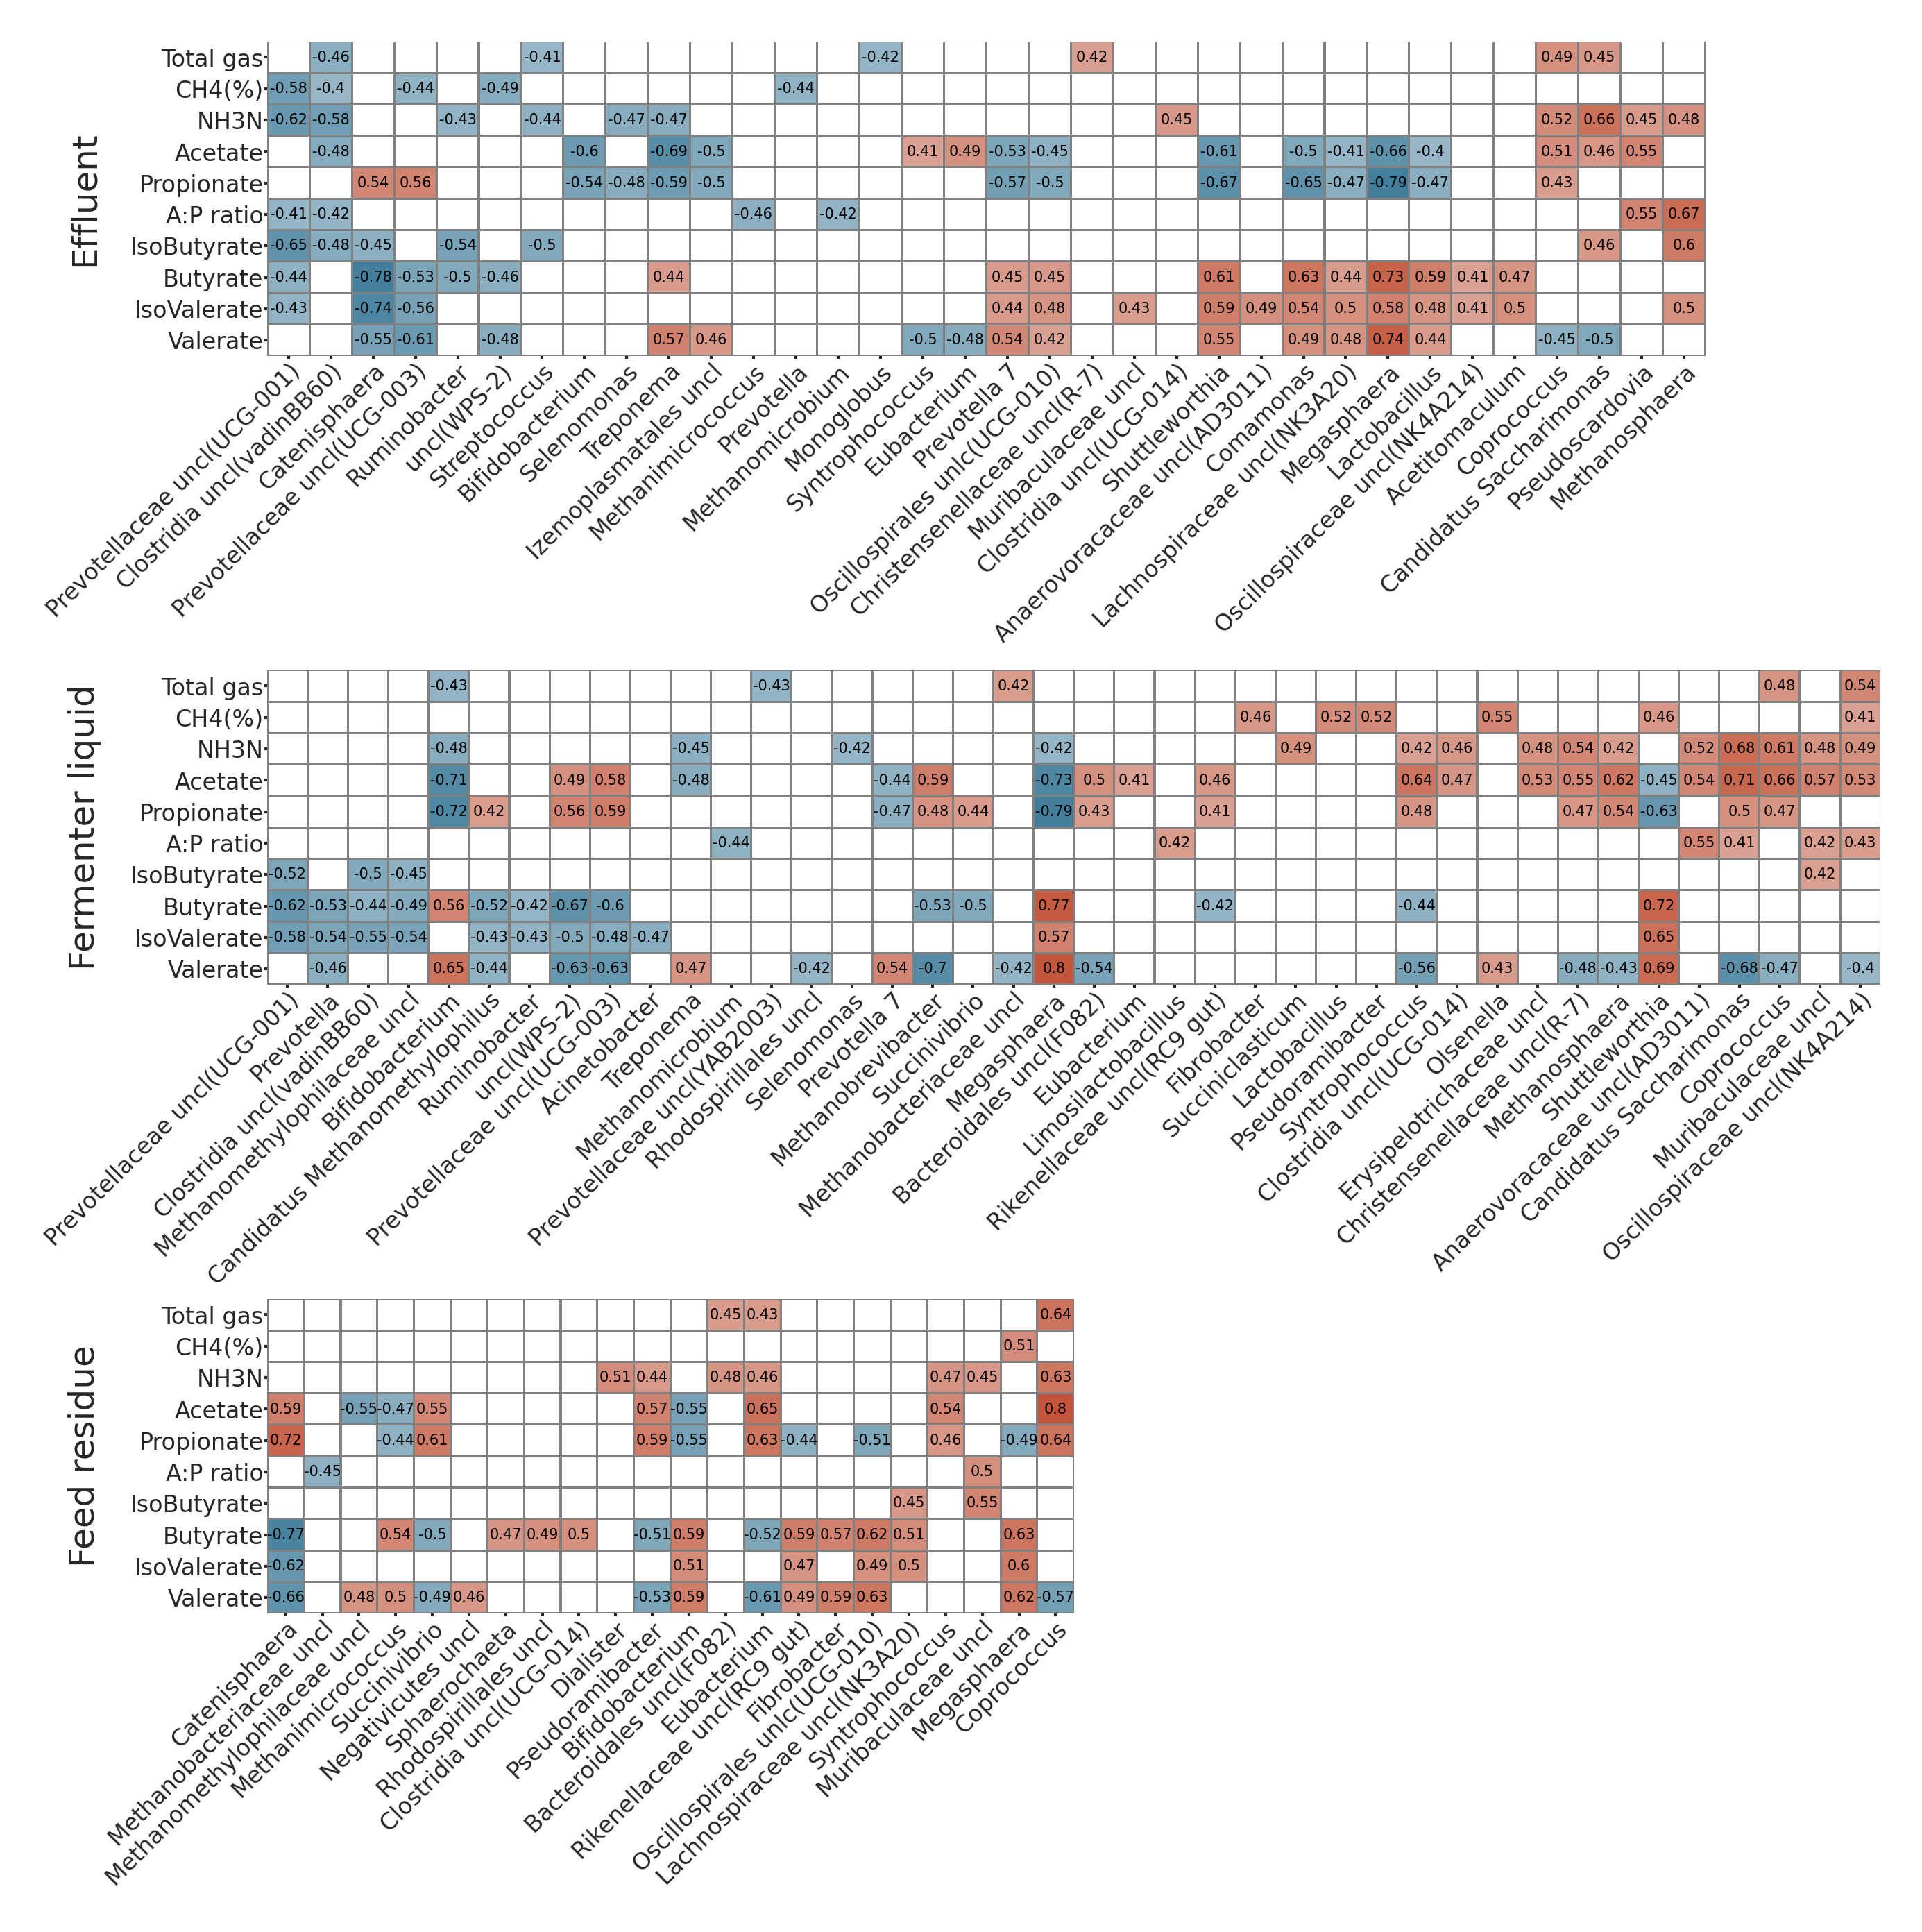

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

def heatmap(hdf,ax,annot,cmap,vmax,vmin):
  sns.heatmap(data=hdf,ax=ax,cbar_kws={'orientation':'horizontal'},annot=annot,
              xticklabels=True,yticklabels=True,cbar=False,square=False,center=0,cmap=cmap,
              vmax=vmax,vmin=vmin,annot_kws={"size":2.5,'c':'black'},linewidths=.25,linecolor='grey')
  ax.set_xlabel('')
  ax.set_ylabel(stypes[bs],fontsize=6,labelpad=5)
  ax.set_xticklabels([feat.replace('_',' ').replace(' nodatum','').replace('Izemoplasmatales','Izemoplasmatales uncl')\
    .replace('Muribaculaceae','Muribaculaceae uncl').replace('uncl(NK4','Oscillospiraceae uncl(NK4')\
    .replace('uncl(UCG-010)','Oscillospirales unlc(UCG-010)').replace('uncl(Family XIII AD3011)','Anaerovoracaceae uncl(AD3011)')\
    .replace('uncl(F082)','Bacteroidales uncl(F082)') for feat in hdf.columns])
  ax.set_yticklabels([x.split('_d')[0] for x in hdf.index])
  ax.tick_params(axis='both',labelsize=4,length=.5,pad=.2,width=0.5)
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  #for _, spine in ax1.spines.items(): 
  #  spine.set_visible(True)
  #  spine.set_linewidth(0.8)
  fig.add_subplot(ax)

   
meta = pd.read_csv('SCNIC/metadata.tsv',sep='\t',index_col='#SampleID')
#meta = meta.loc[(meta.Day!='d0')&(meta.Day_hour!='d13h24')]
meta = meta.loc[(meta.Day!='d0')]
summary = pd.read_csv('SCNIC/SCNIC_summary.tsv',sep='\t',index_col=0)
relabs = pd.read_csv('SCNIC/SCNIC_relabs.tsv',sep='\t',index_col=0)

stypes = {'E':'Effluent','FL':'Fermenter liquid','FR':'Feed residue'}
correlate = ['Tot_gas','CH4_p','NH3N_d','Acetate_d','Propionate_d','Acetate_Propionate','IsoButyrate_d',\
             'Butyrate_d','IsoValerate_d','Valerate_d',]
#correlate = ['Tot_gas','CH4_p','CH4_ml','Acetate_d','Propionate_d','Acetate_Propionate','VFA_d',]
sns.set_style("ticks")
names, i = {'Trt1':'TMR','Trt2':'AN2.5','Trt3':'AN5','Trt4':'FV2.5','Trt5':'FV5',}, 0
stypes = {'E':'Effluent','FL':'Fermenter liquid','FR':'Feed residue','SAM':'SAM'}
data = summary.copy()
vmax,vmin = data.r.max(),data.r.min()
sorter = [c for c in correlate if c in data.feature2.tolist()]
fig = plt.figure(dpi=600,figsize=(5,5))
outer = gridspec.GridSpec(3,1,hspace=1)
ratios = {s:len(df.feature1.unique()) for s,df in data.groupby(by='stype')}
mx = max(list(ratios.values()))

for i,bs in enumerate(sorted(data.stype.unique())):
  inner = gridspec.GridSpecFromSubplotSpec(1,mx,subplot_spec=outer[i],wspace=0)
  ax = plt.Subplot(fig,inner[0,0:ratios[bs]]) 
  #ax = axes[i]
  hdf = data.loc[data.stype==bs].pivot(index='feature1',columns='feature2',values='r')
  hdf = hdf[sorter]
  hdf.dropna(axis=0,how='all',inplace=True,subset=hdf.columns.tolist())
  hdf.rename(columns={'Acetate_Propionate':'A:P ratio','Tot_gas':'Total gas','VFA_d':'Total VFA',\
                      'CH4_ml':'CH4, ml','CH4_p':'CH4(%)'},inplace=True)
  hdf = hdf.T
  hdf = hdf[hdf.sum(0).sort_values(ascending=True).index]
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  heatmap(hdf,ax,True,cmap,vmax,vmin)

plt.savefig('Figures/SCNIC_E_FL_FR.png', bbox_inches='tight')
plt.show()  

In [67]:
#!mkdir SCNIC/Between
!SCNIC_analysis.py between -1 SCNIC/feature-table.biom -2 SCNIC/measurements.biom \
-o SCNIC/Between_pooled/ -m spearman 

In [65]:
import pandas as pd
within = pd.read_csv('SCNIC/Within_features/correls.txt',sep='\t')
within = within.loc[within.p_adjusted <= 0.05]
within = within.loc[(within.r >= 0.8)|(within.r <= -0.8)]
#within = within.loc[(within.feature1.str.contains('Methan'))|(within.feature2.str.contains('Methan'))]
within = within.loc[~((within.feature1.str.contains('Methan'))|(within.feature2.str.contains('Methan')))]
#within = within.loc[(~within.feature1.str.contains('Methanomi'))&(~within.feature2.str.contains('Methanomi'))]
#within = within.loc[(~within.feature1.str.contains('F082'))&(~within.feature2.str.contains('F082'))]
#within = within.loc[(~within.feature1.str.contains('Prevotel'))&(~within.feature2.str.contains('Prevotel'))]
#within = within.loc[(~within.feature1.str.contains('RC9_gut'))&(~within.feature2.str.contains('RC9_gut'))]
display(within)

feature1             feature2       r      p  \
245                      Olsenella      Pseudoscardovia  0.8018  0.001   
247                 Muribaculaceae      Pseudoscardovia  0.8092  0.001   
249                   Prevotella_7      Pseudoscardovia  0.8819  0.001   
259                  Lactobacillus      Pseudoscardovia  0.8517  0.001   
260            Limosilactobacillus      Pseudoscardovia  0.8689  0.001   
266                 Acetitomaculum      Pseudoscardovia  0.8155  0.001   
269   Lachnospiraceae_uncl(NK3A20)      Pseudoscardovia  0.8967  0.001   
270                   Oribacterium      Pseudoscardovia  0.8668  0.001   
277            Eubacterium_nodatum      Pseudoscardovia  0.8433  0.001   
305            Limosilactobacillus            Olsenella  0.8396  0.001   
739                  Catenisphaera     Pseudoramibacter  0.8368  0.001   
751                  Catenisphaera  Eubacterium_nodatum  0.8154  0.001   
869   Lachnospiraceae_uncl(NK3A20)  Limosilactobacillus  0.8068  0.001   
1237                     Dialister  Eubacterium_nodatum  0.8044  0.001   

      p_adjusted  
245     0.001651  
247     0.001651  
249     0.001651  
259     0.001651  
260     0.001651  
266     0.001651  
269     0.001651  
270     0.001651  
277     0.001651  
305     0.001651  
739     0.001651  
751     0.001651  
869     0.001651  
1237    0.001651

# Aldex2

In [1]:
!conda install bioconductor-aldex2 -y -c defaults -c bioconda -c conda-forge
!conda install -y -c dgiguere q2-aldex2
!qiime aldex2 --help

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /home/meco/anaconda3/envs/qiime2-2021.2

  added / updated specs:
    - bioconductor-aldex2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bioconductor-aldex2-1.22.0 |    r40hdfd78af_1         1.0 MB  bioconda
    bioconductor-multtest-2.46.0|    r40hd029910_1         892 KB  bioconda
    openssl-1.1.1l             |       h7f8727e_0         2.5 MB
    r-nada-1.6_1.1             |    r40hc72bb7e_1         530 KB  conda-forge
    r-survival-3.2_11          |    r40hcfec24a_0         6.3 MB  conda-forge
    r-truncnorm-1.0_8          | r40hcfec24a_1002          39 KB  conda-forge
    r-zcompositions-1.3.4      |    r40hc72bb7e_

In [68]:
import pandas as pd
for dom in ['arc','bac']:
  meta = 'rstc_2019_%s/metadata.tsv'%dom
  md = pd.read_csv(meta,sep='\t',index_col=0)
  md = md.loc[md.BS.isin(['SAM','FR','FL','E'])]
  #Filter by sample-types and treatment pairs
  for pair in md.BS_Trt.unique():
    outdir = 'rstc_2019_%s/Results/Aldex2/%s-%s'%(dom,pair[:-1]+'1',pair)
    tabin = 'rstc_2019_%s/Data/Divided_tables/full-table.qza'%dom
    tabex = outdir + '/%s-%s-table.qza'%(pair[:-1]+'1',pair)
    if 'Trt1' in pair: continue
    retain = "[BS_Trt] IN ('%s','%s')"%(pair[:-1]+'1',pair)
    
    !mkdir -p $outdir
    !qiime feature-table filter-samples \
      --i-table $tabin \
      --m-metadata-file $meta \
      --p-where "$retain" \
      --o-filtered-table $tabex
    #filer by relative abundances
    !qiime feature-table filter-features-conditionally \
      --i-table $tabex \
      --p-abundance .01 \
      --p-prevalence .1 \
      --o-filtered-table $tabex
    #aldex2 differentials
    !qiime aldex2 aldex2 \
      --i-table $tabex \
      --m-metadata-file $meta \
      --m-metadata-column Treatment \
      --o-differentials $outdir/differentials.qza
    #aldex2 effect-plot
    !qiime aldex2 effect-plot \
      --i-table $outdir/differentials.qza \
      --o-visualization $outdir/effect-plots.qzv
    #aldex2 extract-differences
    !qiime aldex2 extract-differences \
      --i-table $outdir/differentials.qza \
      --o-differentials $outdir/sig-differentials.qza \
      --p-sig-threshold 0.1 \
      --p-effect-threshold 0 \
      --p-difference-threshold 0
    #export
    !qiime tools export \
      --input-path $outdir/sig-differentials.qza \
      --output-path $outdir
  #relative abundances for plots
  relin = 'rstc_2019_%s/Data/Relative_tables/full-relative_table.qza'%dom
  out = 'rstc_2019_%s/Results/Aldex2'%(dom)
  !qiime tools export \
    --input-path $relin \
    --output-path $out
  !biom convert -i $out/feature-table.biom -o $out/feature-table.tsv --to-tsv 

Saved FeatureTable[Frequency] to: rstc_2019_arc/Results/Aldex2/FL_Trt1-FL_Trt2/FL_Trt1-FL_Trt2-table.qza
Saved FeatureTable[Frequency] to: rstc_2019_arc/Results/Aldex2/FL_Trt1-FL_Trt2/FL_Trt1-FL_Trt2-table.qza
Saved FeatureData[Differential] to: rstc_2019_arc/Results/Aldex2/FL_Trt1-FL_Trt2/differentials.qza
Saved Visualization to: rstc_2019_arc/Results/Aldex2/FL_Trt1-FL_Trt2/effect-plots.qzv
Plugin error from aldex2:

  You have selected a significance threshold that is lower than minimum Q score (-p--sig-threshold). Select a higher threshold.

Debug info has been saved to /tmp/qiime2-q2cli-err-es1cf0_b.log
Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory w

In [69]:
import pandas as pd
import os

for dom in ['arc','bac']:
  meta = 'rstc_2019_%s/Results/Core-metrics/alpha.tsv'%dom
  md = pd.read_csv(meta,sep='\t',index_col=0)
  md = md.loc[md.BS.isin(['SAM','FR','FL','E'])]
  summ = pd.DataFrame()
  out = 'rstc_2019_%s/Results/Aldex2'%(dom)
  for pair in md.BS_Trt.unique():
    if 'Trt1' in pair: continue
    outdir = 'rstc_2019_%s/Results/Aldex2/%s-%s'%(dom,pair[:-1]+'1',pair)
    if 'differentials.tsv' not in os.listdir(outdir): continue
    aldex = pd.read_csv(outdir+'/differentials.tsv',sep='\t',skiprows=[1])
    aldex['BS'],aldex['Treatment'] = pair.split('_')
    rename = [c for c in aldex.columns if 'rab.win.Trt' in c if 'Trt1' not in c][0]
    aldex.rename(columns={'rab.win.Trt1':'rab.win.TMR', rename:'rab.win.Trt'}, inplace=True)
    summ = pd.concat([summ,aldex],ignore_index=True)
  summ.to_csv(out+'/aldex-summ.tsv',sep='\t',index=False)
  
  #add rel ab
  relab,i = pd.DataFrame(),0
  data = pd.read_csv(out+'/feature-table.tsv',sep='\t',skiprows=1,index_col=0)
  for bs in md.BS.unique():
    for feat in summ.loc[summ.BS==bs.split('_')[0]]['featureid'].unique():
      relab.loc[i,'featureid'] = feat
      relab.loc[i,'BS'] = bs
      for trt in md.Treatment.unique():
        submd = md.loc[md.BS_Trt==bs+'_'+trt]
        subdata = data[submd.index].copy()
        subdata['mean'] = subdata.mean(axis=1)
        relab.loc[i,trt] = subdata.loc[feat,'mean']
      i += 1
  relab.to_csv(out+'/relabs.tsv',sep='\t',index=False)

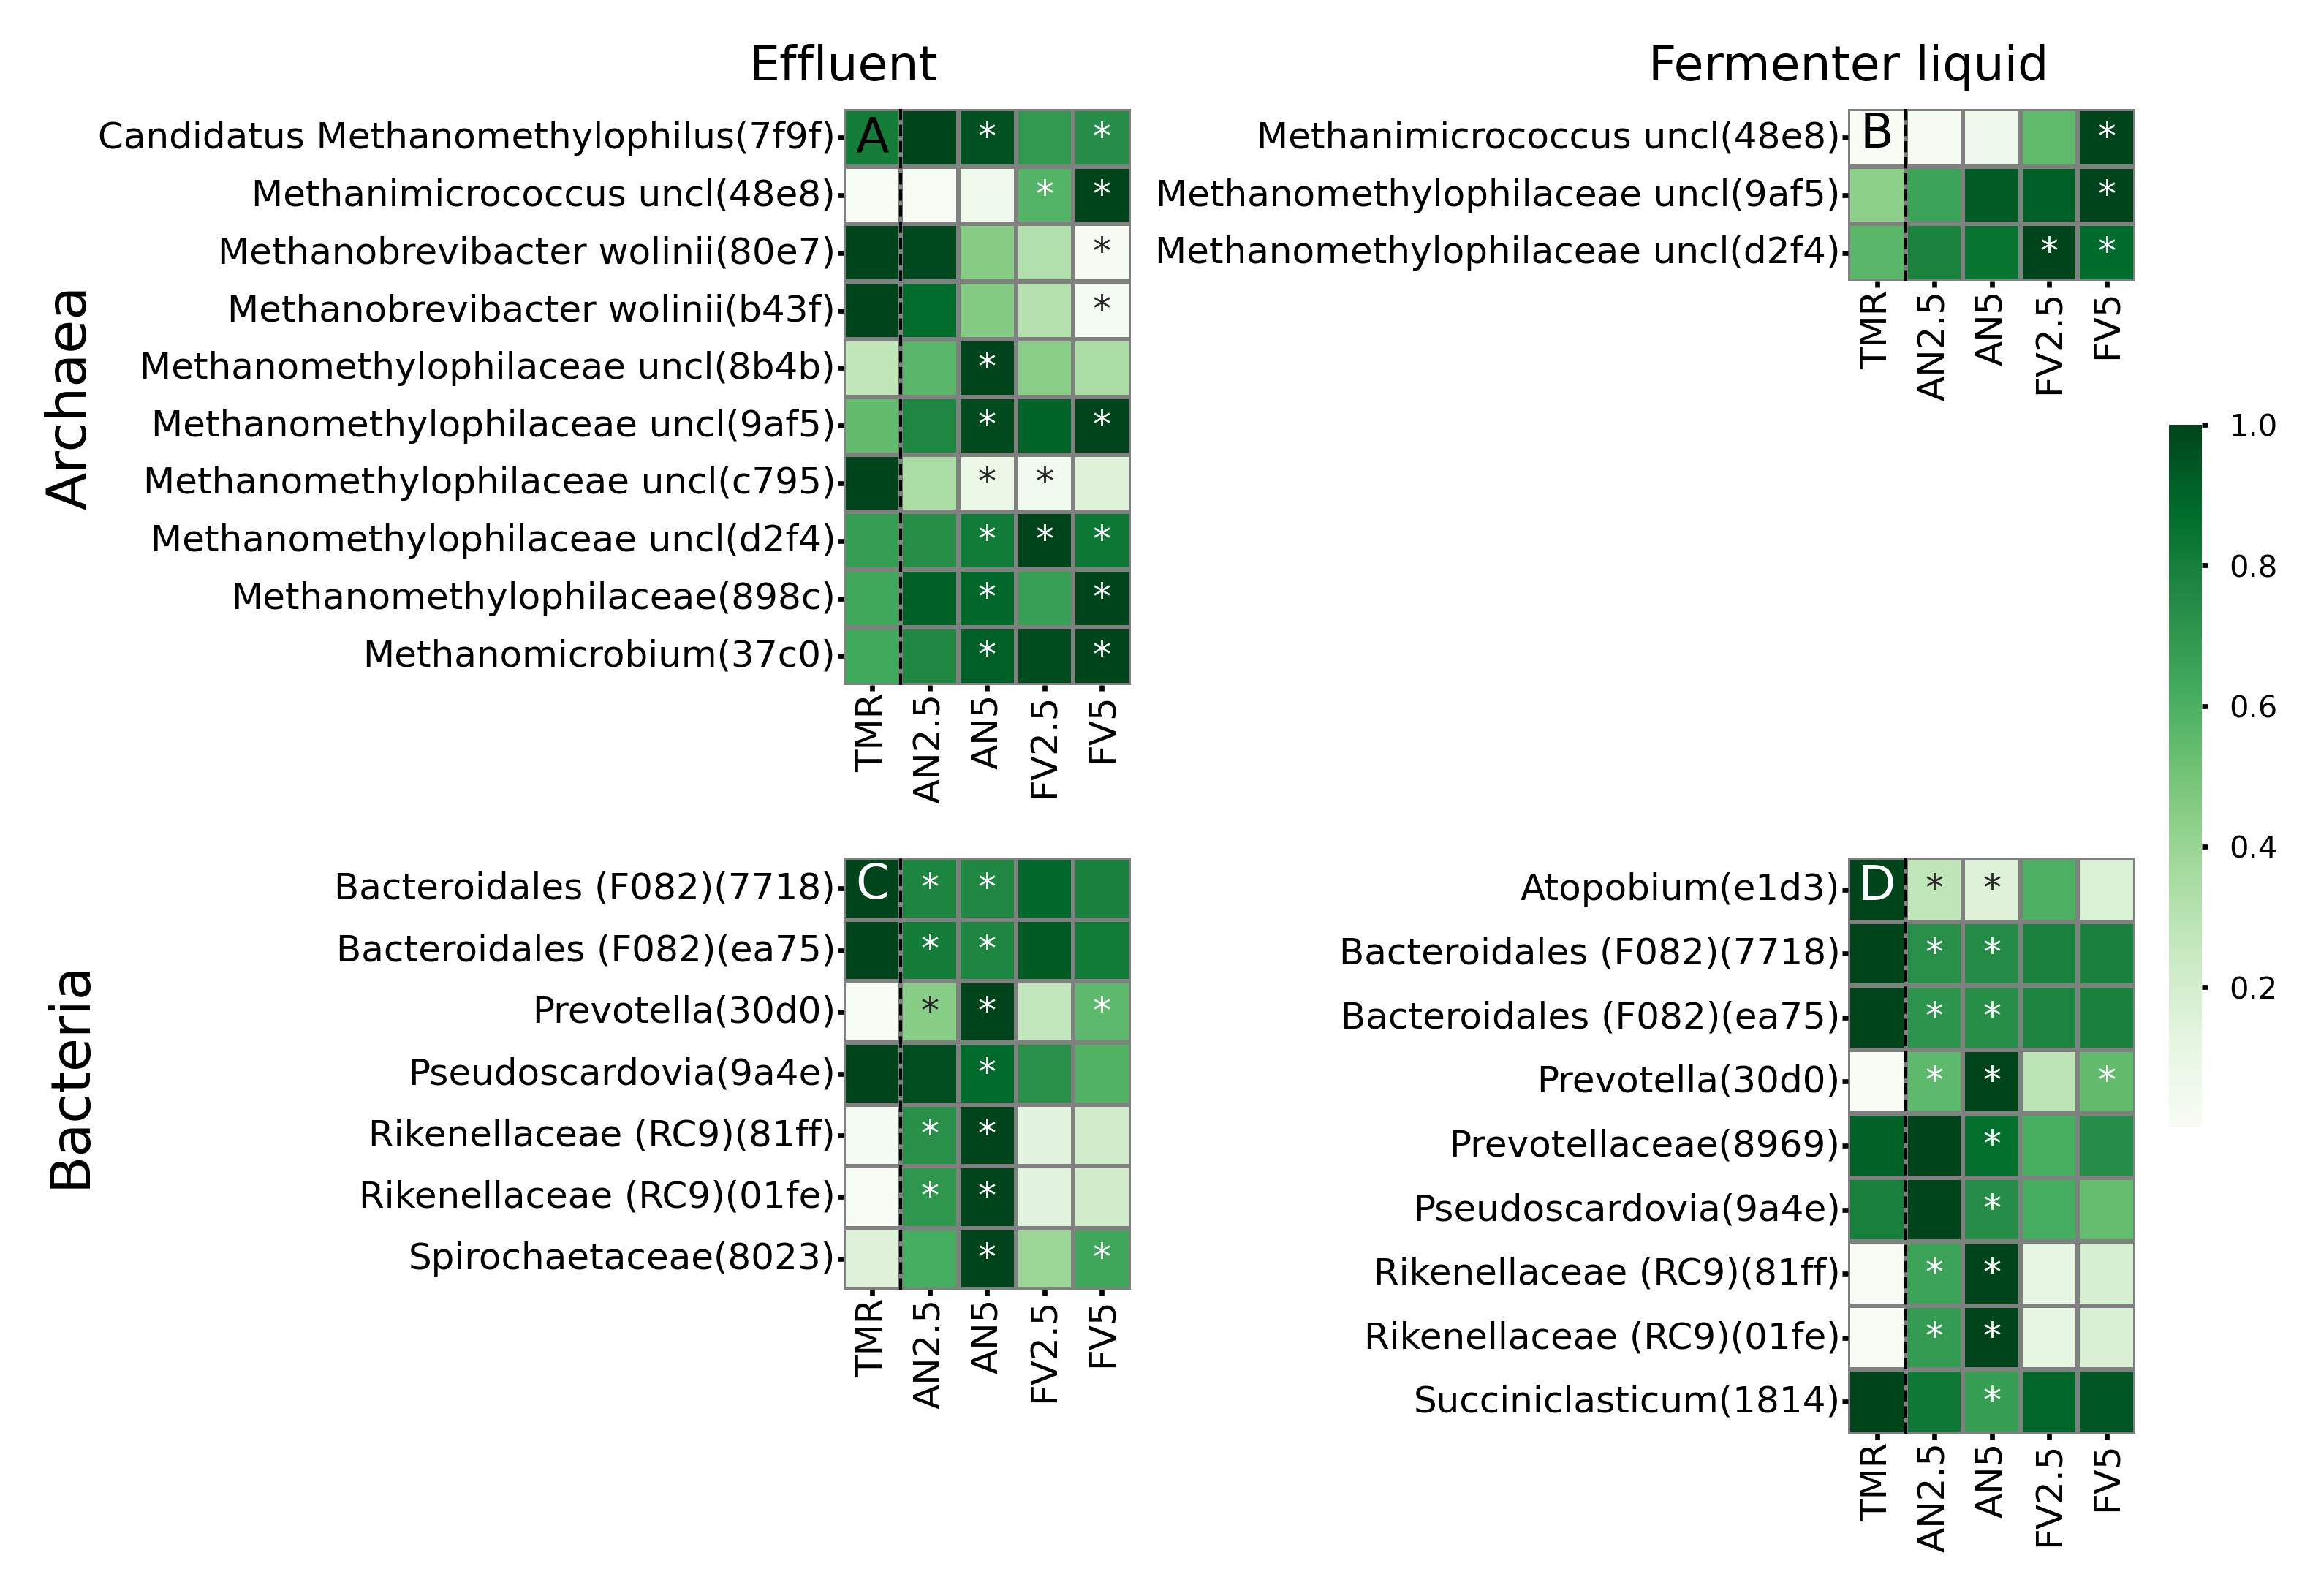

In [67]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

names, i = {'Trt1':'TMR','Trt2':'AN2.5','Trt3':'AN5','Trt4':'FV2.5','Trt5':'FV5',}, 0
stypes = {'E':'Effluent','FL':'Fermenter liquid'}
domains = {'arc':'Archaea','bac':'Bacteria'}

fig,axes = plt.subplots(2,2,dpi=600,figsize=(3.8,4),gridspec_kw={'wspace':2.5,'hspace':.3})
cbar_ax = fig.add_axes([.92, .3, .02, .4])
cbar_ax.tick_params(labelsize=5,length=1)
axs,i = [[n,m] for n in range(2) for m in range(2)],0
for dom in domains:
  out = 'rstc_2019_%s/Results/Aldex2'%(dom)
  summ = pd.read_csv(out+'/aldex-summ.tsv',sep='\t')
  relab = pd.read_csv(out+'/relabs.tsv',sep='\t',index_col='featureid')
  for bs in stypes:
    data = relab.loc[relab.BS==bs].copy()
    data.drop(['BS'],axis=1,inplace=True)
    data = data.div(data.max(axis=1),axis=0)
    data = data.sort_index()
    ax, i = axes[axs[i][0]][axs[i][1]], i+1
    if dom=='arc': ax.text(0,1.05,stypes[bs],ha='center',fontsize=8,transform=ax.transAxes)
    #adjust height of axes with smaller number of ASVs
    if i == 2:
      ax.axis('off')
      ax = ax.inset_axes([0,0.7,1,0.3])
    if i == 3:
      ax.axis('off')
      ax = ax.inset_axes([0,0.25,1,0.75])
    stars = []
    for feat in data.index:
      aldex = summ.loc[(summ.featureid==feat)&(summ.BS==bs)]['Treatment'].tolist()
      stars.append(['*' if c in aldex else '' for c in data.columns])
    addstars = np.array(stars)
    sns.heatmap(data=data,ax=ax, annot=addstars,fmt='',cmap='Greens',
            xticklabels=True,yticklabels=True,cbar_ax=cbar_ax,
            linewidths=.5,linecolor='grey',annot_kws={"size":6,})
    ylab = [item.get_text() for item in ax.get_yticklabels()]
    ylab = [l.replace('_u_methanogenic_a','').replace('RC9_gut_gr','(RC9)').replace('_u_r','')\
            .replace('_u_b','').replace('unid_methanogen','uncl').replace('F082','Bacteroidales_(F082)')\
            .replace('philus_uncl','philus').replace('_',' ') for l in ylab]
    ax.set_yticklabels([y.split('|')[0] +'('+ y.split('|')[-1][:4] +')' for y in ylab])
    xlab = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([names[x] for x in xlab])
    ax.tick_params(axis='both',which='major',labelsize=6,length=1,pad=0.3)
    ax.axvline(x=1,ymin=0,ymax=1,c='black',ls='--',lw=.5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    c = 'black'
    if dom == 'bac': c = 'white'
    ax.text(.1,.99,'ABCD'[i-1],ha='center',va='top',fontsize=8,transform=ax.transAxes,color=c)
    if bs == 'E': ax.set_ylabel(domains[dom],fontsize=9,labelpad=5)
    ax.get_yaxis().set_label_coords(-2.6,0.5)
#fig.align_labels()
plt.savefig('Figures/Aldex2_heatmap.png',bbox_inches='tight')